# Quantify how IOU relates to areas "missed" and "in excess" for figures

Here we do a simple calculation of how much area is "missing" or "in excess" for different IOU cut-offs.

## Load previous weights

In [1]:
import config

In [2]:
# We have a winner!
binary_dirs = 'binaries_model12_tfrecordz/'
weightsFileDir = config.save_weights_dir +'saved_weights/'+'20211218_model12tfz/'
weightsFile = 'training_1model12_tfrec_model_l0.019131713.h5'  
#use_training = False
#use_valid = True

save_fig_name_base = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper2/ref_figures/iou_dist_'

In [3]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from general_utils import iou_orig

In [4]:
# training set
binary_dirs = 'binaries_model12_tfrecordz/'# for final test set
save_fig_name = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper2/ref_figures/iou_dist_figures'

# use train and valid for this calc
use_splits = ['train', 'valid']

In [5]:
truebox_out = []
foundbox_out = []
foundscore_out = []
foundlabel_out = []
img_names = []
for adder in use_splits:
    pp = config.metric_results_dir
    pp += binary_dirs.split('/')[0]
    pp += '_'+adder
    pp += '.pickle'
    print(pp)
    
    with open(pp, 'rb') as ff:
        icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                     bbox_figcap_pars,\
                     sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                     boxes_pdf, labels_pdf, scores_pdf,\
                     boxes_heur, labels_heur, scores_heur,\
                     boxes_heur2, labels_heur2, scores_heur2,\
                     boxes_par_found, labels_par_found, scores_par_found,\
                     boxes_sq1, labels_sq1, scores_sq1,\
                     boxes_sq2, labels_sq2, scores_sq2,\
                     boxes_sq3, labels_sq3, scores_sq3,\
                     boxes_sq4, labels_sq4, scores_sq4,\
                     boxes_sq5, labels_sq5, scores_sq5,\
                     truebox1,truebox2,truebox3,rotatedImage,\
        LABELS,boxes1, scores1, labels1 = pickle.load(ff)
        truebox_out.extend(truebox3); foundbox_out.extend(boxes_sq5)
        foundscore_out.extend(scores_sq5); foundlabel_out.extend(labels_sq5)
        img_names.extend(imgs_name)

/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_tfrecordz_train.pickle
/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_tfrecordz_valid.pickle


In [6]:
icount_not_matched = 0
icount_mislabeled = 0
tfpairs = [] # order will be true, false
for im,t,f,fl in zip(img_names,truebox_out, foundbox_out,foundlabel_out):
    if len(t) != len(f): # for now, ignore these
        #import sys; sys.exit()
        icount_not_matched+=1
    else: # match!
        # order by centers
        vt = []; vf = []; tl = []
        for tt in t:
            #x1min,y1min,x1max,y1max
            vt.append( ((tt[0]+tt[2])*0.5, (tt[1]+tt[3])*0.5) )
            tl.append(tt[-1])
        for ff in f:
            vf.append( ((ff[0]+ff[2])*0.5, (ff[1]+ff[3])*0.5) )
        # find closest found
        vf_out = []; fl_out = []
        vf = np.array(vf)
        for tt,ttl,totalt in zip(vt,tl,t):
            v = np.sqrt((tt[0]-vf[:,0])**2+(tt[1]-vf[:,1])**2)
            ind = np.argmin(v)
            # check right class
            if fl[ind]+1 != ttl:
                icount_mislabeled += 1
            else:                
                #vf_out.append(vf[ind,:])
                #fl_out.append(fl[ind])
                tfpairs.append( (totalt[:-1], f[ind], fl[ind]+1) )
        #import sys; sys.exit()
        # also check that the same kind of object!!
print(icount_not_matched, icount_not_matched/len(img_names))
print(icount_mislabeled, icount_mislabeled/len(img_names))

196 0.03946838501812324
52 0.010471204188481676


In [7]:
tfpairs[0]

(array([ 54., 374., 453., 384.]),
 array([ 54.01098039, 373.60484848, 452.56784314, 383.68969697]),
 2)

In [8]:
ious_figs = []; ious_caps = []; ious_tabs = []; ious_math = []; save_inds = []; ious_all = []
excess_figs = []; excess_caps = []; excess_tabs = []; excess_math = [];
loss_figs = []; loss_caps = []; loss_tabs = []; loss_math = [];
count_nonoverlap = 0; count_overlap = 0
for ii,tf in enumerate(tfpairs):
    #iou2 = []
    iou1 = -2; inter=-1
    t = tf[0]; f = tf[1]
    lf=lt=tf[-1]
    area_excess = 0; area_loss = 0
    x1min,y1min,x1max,y1max = np.array(f).copy()
    x2min,y2min,x2max,y2max = np.array(t).copy()
    # calc iou
    w1,h1 = x1max-x1min,y1max-y1min
    x1,y1 = x1min+0.5*w1, y1min+0.5*h1
    w2,h2 = x2max-x2min,y2max-y2min
    x2,y2 = x2min+0.5*w2, y2min+0.5*h2
    inter,union,iou1 = iou_orig(x1,y1,w1,h1, x2,y2,w2,h2,return_individual=True)
    if iou1 > 1: import sys; sys.exit()
    #if iou1 < 0: import sys; sys.exit()# non-overlapping
    iouind = int(lt-1)
    # is true inside found?
    if iou1 > 0: # have to be overlapping
        count_overlap+=1
        if x1min<=x2min and y1min<=y2min and \
           y1max >= y2max and x1max >= x2max:
            covered = 1
            # by how much?
            a1 = (x1max-x1min)*(y1max-y1min)
            a2 = (x2max-x2min)*(y2max-y2min)
            area_excess = (a1-a2)/a1 # function of found, make negative for found
        else: # there is some excess and some loss
            # excess is extra found
            atrue = (x2max-x2min)*(y2max-y2min)
            area_excess = ((x1max-x1min)*(y1max-y1min)-inter)/atrue
            # loss is extra true
            area_loss = ((x2max-x2min)*(y2max-y2min)-inter)/atrue
    else:
        iou1 = -2 # not overlapping, tag as such
        count_nonoverlap += 1
                
    if iou1 > -2: 
        save_inds.append(ii)
        if LABELS.index('figure') == iouind:
            ious_figs.append(iou1)
            excess_figs.append(area_excess)
            loss_figs.append(area_loss)
        elif LABELS.index('figure caption') == iouind:
            ious_caps.append(iou1)
            excess_caps.append(area_excess)
            loss_caps.append(area_loss)
        elif LABELS.index('table') == iouind: # note math & table not really tracked right now
            ious_tabs.append(iou1)
            excess_tabs.append(area_excess)
            loss_tabs.append(area_loss)
        elif LABELS.index('math formula') == iouind:
            ious_math.append(iou1)
            excess_math.append(area_excess)
            loss_math.append(area_loss)
        else:
            import sys; sys.exit()
        #iou2.append((iou1,inter))
    ious_all.append((iou1,inter))


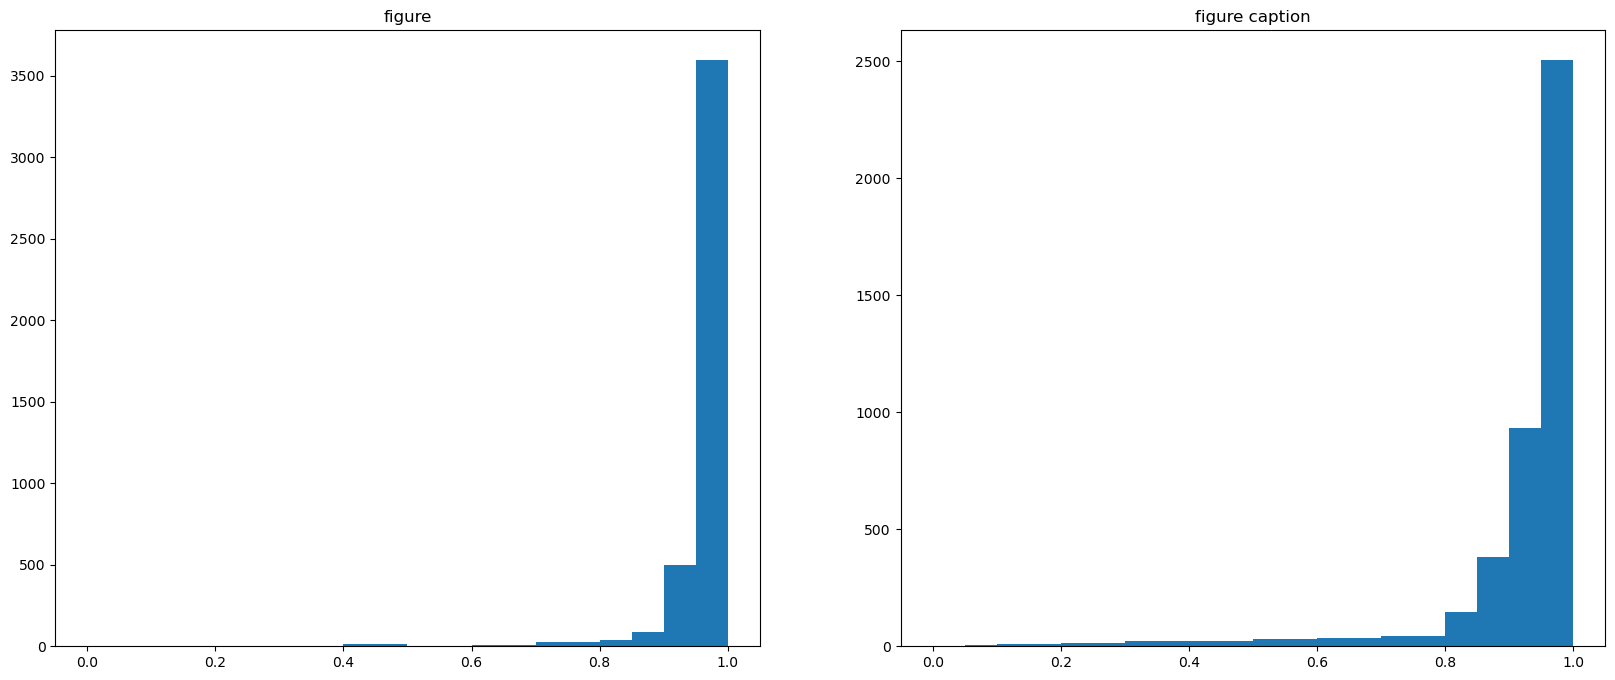

In [9]:
#fig, ax = plt.subplots(1,4,figsize=(20,8))
fig, ax = plt.subplots(1,2,figsize=(20,8))
bins = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]

ax[0].hist(ious_figs, bins=bins)
ax[0].set_title('figure')

ax[1].hist(ious_caps, bins=bins)
ax[1].set_title('figure caption')

# ax[2].hist(ious_tabs, bins=bins)
# ax[2].set_title('table')

# ax[3].hist(ious_math, bins=bins)
# ax[3].set_title('math formula')

plt.show()

In [10]:
excess_figs = np.array(excess_figs)
excess_caps = np.array(excess_caps)
loss_figs = np.array(loss_figs)
loss_caps = np.array(loss_caps)
ious_figs = np.array(ious_figs)
ious_caps = np.array(ious_caps)

In [11]:
mask = excess_figs > -1 # fig has some excess

# total ious:
ioum = ious_figs[mask]
print(len(ioum), len(ioum[ioum>0.8]))
print(len(ioum[ioum>0.8])/len(ioum))

# min & max excess in this range
emin = excess_figs[mask][ioum>0.8].min()
emax = excess_figs[mask][ioum>0.8].max()
print(emin,emax)

4278 4227
0.988078541374474
-6.329671695679362e-16 0.22957129715445618


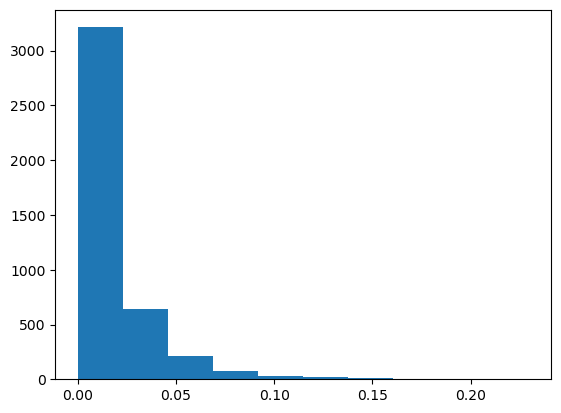

In [12]:
plt.hist(excess_figs[mask][ioum>0.8])
plt.show()

What is the maximum excess percent for 90% of this distribution?

In [13]:
iou_trial = 0.9

np.percentile(excess_figs[mask][ioum>iou_trial],90)

0.03890860936521847

So, for an IOU of 0.8, 90% of the excess stuff around figures is $\leq$ 4.28%

Or, the other way: what if we say we want the MAX excess to be 5% -- what is the minimum IOU for this?

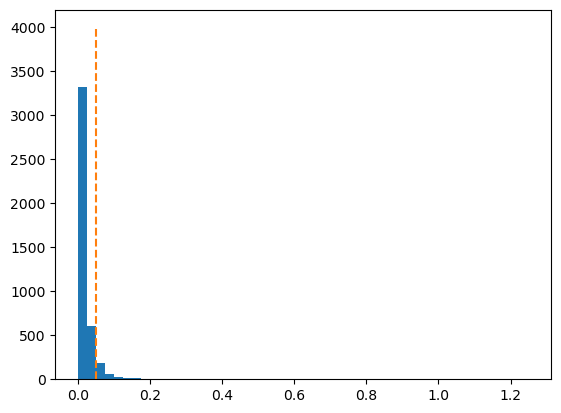

In [14]:
plt.hist(excess_figs[mask],bins=50)
plt.plot([0.05, 0.05],[0,4000],'--')
plt.show()

In [15]:
ioum2 = ious_figs[mask][excess_figs[mask] <=0.05]
ioum2.min(), ioum2.max()

(0.3958290461413411, 0.9994029160789061)

Or!  What is the IOU when 90% of the excess for figs is $\leq$ 5%? ... wait this maybe doesn't make sense...

In [16]:
# cut_off_excess = 0.05
# dist_cut_off = 0.9

# # this is the excess where it is 
# ex = excess_figs[mask][excess_figs[mask] <= cut_off_excess]
# np.percentile(ex,100-dist_cut_off*100)

Ok, how about what is the 90%-percentile min-IOU for the excess in figs $\leq$ 5%?

In [17]:
cut_off_excess = 0.05
dist_cut_off = 0.9

ioum2 = ious_figs[mask][excess_figs[mask] <=cut_off_excess]

np.percentile(ioum2, 100-dist_cut_off*100)

0.9527685316856412

What about for 10%? 20%?

In [18]:
cut_off_excess = 0.1
dist_cut_off = 0.9

ioum2 = ious_figs[mask][excess_figs[mask] <=cut_off_excess]

np.percentile(ioum2, 100-dist_cut_off*100)

0.9416995075865314

In [19]:
cut_off_excess = 0.2
dist_cut_off = 0.9

ioum2 = ious_figs[mask][excess_figs[mask] <=cut_off_excess]

np.percentile(ioum2, 100-dist_cut_off*100)

0.9376609238316526

Now, what about for loss?

In [20]:
mask = loss_figs > -1 # fig has some excess

cut_off_loss = 0.05
dist_cut_off = 0.9

ioum2 = ious_figs[mask][loss_figs[mask] <=cut_off_loss]

np.percentile(ioum2, 100-dist_cut_off*100), np.round(np.percentile(ioum2, 100-dist_cut_off*100),1)

(0.9468730006691312, 0.9)

What about 10% and 20%?

In [21]:
cut_off_loss = 0.1
dist_cut_off = 0.9

ioum2 = ious_figs[mask][loss_figs[mask] <=cut_off_loss]

np.percentile(ioum2, 100-dist_cut_off*100)

0.9389340499022037

In [22]:
cut_off_loss = 0.2
dist_cut_off = 0.9

ioum2 = ious_figs[mask][loss_figs[mask] <=cut_off_loss]

np.percentile(ioum2, 100-dist_cut_off*100)

0.9360439923393656

Same thing, but for captions:

In [23]:
#cut_off_excess = 0.05
dist_cut_off = 0.90

mask = excess_caps > -1 # has some excess
print('EXCESS CAPS')
for cut_off in [0.05, 0.1, 0.2]:
    ioum2 = ious_caps[mask][excess_caps[mask] <=cut_off]
    print('for cut_off=', cut_off, 'and', 'dist-cut-off=', dist_cut_off)
    print('iou cut off, rounded to 1-decimal:')
    print('   ',np.percentile(ioum2, 100-dist_cut_off*100), np.round(np.percentile(ioum2, 100-dist_cut_off*100),1))
    print('')
    
mask = loss_caps > -1 # has some loss
print("LOSS CAPS")
for cut_off in [0.05, 0.1, 0.2]:
    ioum2 = ious_caps[mask][loss_caps[mask] <=cut_off]
    print('for cut_off=', cut_off, 'and', 'dist-cut-off=', dist_cut_off)
    print('iou cut off, rounded to 1-decimal:')
    print('   ',np.percentile(ioum2, 100-dist_cut_off*100), np.round(np.percentile(ioum2, 100-dist_cut_off*100),1))
    print('')

EXCESS CAPS
for cut_off= 0.05 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9164428322508498 0.9

for cut_off= 0.1 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.8952830031832051 0.9

for cut_off= 0.2 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.8828472382115773 0.9

LOSS CAPS
for cut_off= 0.05 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9105377214345949 0.9

for cut_off= 0.1 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.886447454254756 0.9

for cut_off= 0.2 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.874466745309163 0.9



All in one place for figs too:

In [24]:
dist_cut_off = 0.90

mask = excess_figs > -1 # has some excess
print('EXCESS FIGS')
for cut_off in [0.05, 0.1, 0.2]:
    ioum2 = ious_figs[mask][excess_figs[mask] <=cut_off]
    print('for cut_off=', cut_off, 'and', 'dist-cut-off=', dist_cut_off)
    print('iou cut off, rounded to 1-decimal:')
    print('   ',np.percentile(ioum2, 100-dist_cut_off*100), np.round(np.percentile(ioum2, 100-dist_cut_off*100),1))
    print('')
    
mask = loss_figs > -1 # has some loss
print("LOSS FIGS")
for cut_off in [0.05, 0.1, 0.2]:
    ioum2 = ious_figs[mask][loss_figs[mask] <=cut_off]
    print('for cut_off=', cut_off, 'and', 'dist-cut-off=', dist_cut_off)
    print('iou cut off, rounded to 1-decimal:')
    print('   ',np.percentile(ioum2, 100-dist_cut_off*100), np.round(np.percentile(ioum2, 100-dist_cut_off*100),1))
    print('')

EXCESS FIGS
for cut_off= 0.05 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9527685316856412 1.0

for cut_off= 0.1 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9416995075865314 0.9

for cut_off= 0.2 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9376609238316526 0.9

LOSS FIGS
for cut_off= 0.05 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9468730006691312 0.9

for cut_off= 0.1 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9389340499022037 0.9

for cut_off= 0.2 and dist-cut-off= 0.9
iou cut off, rounded to 1-decimal:
    0.9360439923393656 0.9



Plotting these cut offs, which it seems to be for $\leq$ 5% loss and $\leq$ 10% excess, and the 90% of the IOU distribution:

In [25]:
# for x in xs:
#     print(x.min())

In [26]:
import matplotlib.patches as pt

In [27]:
#np.histogram2d?

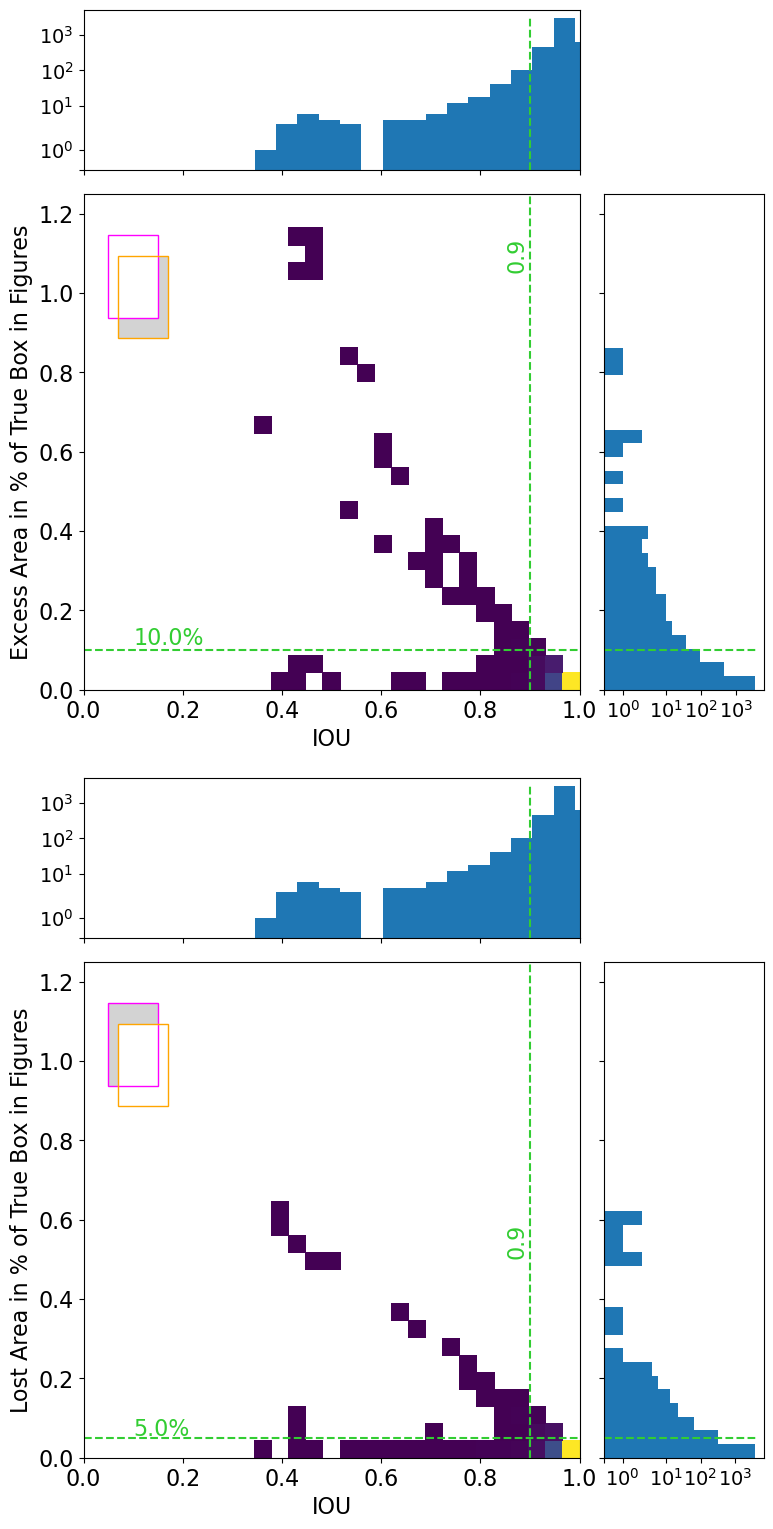

In [28]:
percent_out = 90

font = {'weight':'normal','size'   : 16}
matplotlib.rc('font', **font)
axes_labelsize = 14

# 1x4
nbins = 30

xlims = (0,1)
ylims = (0, 1.25)

#(x_edges, y_edges = bins)
nbins = [np.linspace(xlims[0],xlims[1],nbins), np.linspace(ylims[0],ylims[1],nbins)]

nPlots = 2
# start with a rectangular Figure
sfig = 8
# debug
#sfig=4
fig = plt.figure(1, figsize=(sfig, sfig*nPlots))
nullfmt = NullFormatter()         # no labels

axScatters = []; axHistxs = []; axHistys = []

wall = 0.62

debug = False

for i in range(nPlots):
    # definitions for the axes
    left, width = 0.1, wall
    bottom, height = 0.1/nPlots/nPlots+(1-(0.65+wall/nPlots)/nPlots*(i+1)), wall/nPlots
    left_h = left + width + 0.03
    bottom_h = bottom + height + 0.03/nPlots
    
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_h, bottom, 0.2, height]
    rect_histx = [left, bottom_h, width, 0.2/nPlots]
    
    axScatters.append(plt.axes(rect_scatter,label='s'+str(i)))
    axHistys.append(plt.axes(rect_histy,label='y'+str(i)))
    axHistxs.append(plt.axes(rect_histx,label='x'+str(i)))
    


xs = []; ys = []; ytits = []
#excess figs
mask = excess_figs > -1
x = ious_figs[mask]; y = excess_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figures')
# loss figs
mask = loss_figs > -1
x = ious_figs[mask]; y = loss_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figures')
#excess caps
mask = excess_caps > -1
x = ious_caps[mask]; y = excess_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figure Captions')
# loss caps
mask = loss_caps > -1
x = ious_caps[mask]; y = loss_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figure Captions')
type_plot = ['excess','loss','excess','loss']

# # calcs
# xps=[]; yps=[]
# for x,y, in zip(xs,ys):
#     yp = np.percentile(y,percent_out)
#     xp = np.percentile(x,100-percent_out)
#     xps.append(xp); yps.append(yp)

# fig excess, fig loss, cap excess, cap loss
yps = [0.10, 0.05, 0.1, 0.05]
# IOUs
xps = [0.9, 0.9, 0.9, 0.9]

w = 0.1; h = 0.2
# xmin, ymin, w, h - true
x1 = 0.05; y1 = 0.9; x2 = x1+w; y2 = y1+h
ctrue = 'magenta'
# xmin, ymin, w, h - found
x1fh = 0.07; y1fh = 0.85; x2fh = x1fh+w; y2fh = y1fh+h
cfound='orange'
# scales
bx1 = 0.0; bx2 = 1.0; by1 = 0.0; by2 = 1.2

#lines_text_color = 'darkolivegreen'
lines_text_color = 'limegreen'


for x,y,axScatter,axHistx,axHisty,ytit,xp,yp,tp in zip(xs,ys,axScatters,axHistxs,axHistys,ytits,xps,yps,type_plot):
    # the scatter plot:
    axScatter.hist2d(x,y, cmap='viridis',cmin=1, bins=nbins)
    #axScatter.set_xlim((x.min(),x.max()))
    axScatter.set_xlim(xlims)
    #axScatter.set_ylim((y.min(),y.max()))
    axScatter.set_ylim(ylims)
    axScatter.set_xlabel('IOU')
    axScatter.set_ylabel(ytit)
    axScatter.plot([xp,xp],axScatter.get_ylim(),'--', color=lines_text_color)
    axScatter.plot(axScatter.get_xlim(),[yp,yp],'--', color=lines_text_color)
    
    # where do x/y text live?
    axScatter.text(0.1,yp+0.01*(y.max()-y.min()), str(round(yp*100,2))+'%',color=lines_text_color)
    axScatter.text(xp-0.05, 0.85*(y.max()-y.min()), str(round(xp,3)),color=lines_text_color,rotation=90)

    # x-side histogram
    axHistx.hist(x, bins=nbins[1])
    axHistx.plot([xp,xp],axHistx.get_ylim(),'--', color=lines_text_color)

    # y-side histogram
    axHisty.hist(y, bins=nbins[0], orientation='horizontal')
    axHisty.plot(axHisty.get_xlim(),[yp,yp],'--', color=lines_text_color)

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_yscale('symlog')
    axHisty.set_xscale('symlog') # note in this case its x-scale because flipped!
    
    # draw boxes, rescale so same on all plots
    # true
    x1t = (x1-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    x2t = (x2-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    y1t = (y1-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    y2t = (y2-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    # true
    x1f = (x1fh-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    x2f = (x2fh-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    y1f = (y1fh-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    y2f = (y2fh-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    
    # shade excess
    if tp == 'excess':
        # first
        x1e = x1f; x2e = x2f
        y1e = y1f; y2e = y1t
        recte1 = pt.Rectangle((x1e, y1e), x2e - x1e, y2e - y1e, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte1)
        # second
        x1e2 = x2t; x2e2 = x2f
        y1e2 = y1f; y2e2 = y2f
        recte2 = pt.Rectangle((x1e2, y1e2), x2e2 - x1e2, y2e2 - y1e2, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte2)
    else: #loss
        # first
        x1e = x1t; x2e = x1f
        y1e = y1t; y2e = y2t
        recte1 = pt.Rectangle((x1e, y1e), x2e - x1e, y2e - y1e, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte1)
        # second
        x1e2 = x1f; x2e2 = x2t
        y1e2 = y2f; y2e2 = y2t
        recte2 = pt.Rectangle((x1e2, y1e2), x2e2 - x1e2, y2e2 - y1e2, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte2)
    
    
    # draw true/found boxes
    rectt = pt.Rectangle((x1t, y1t), x2t - x1t, y2t - y1t, linewidth=1, edgecolor=ctrue,
                             facecolor='none')
    axScatter.add_patch(rectt)
    
    rectf = pt.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=1, edgecolor=cfound,
                             facecolor='none')
    axScatter.add_patch(rectf)
    



# # no labels
for axHistx in axHistxs:
    axHistx.xaxis.set_major_formatter(nullfmt)
    #axHisty.xaxis.set_minor_locator(plt.MaxNLocator(3))
for axHisty in axHistys:
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    
fig.canvas.draw() # to get tick marks
for axHisty in axHistys:
    # set no 0 for sym log
    yxticks = ['']
    for t in axHisty.get_xticklabels()[1:]:
        #print(t)
        yxticks.append(t.get_text())
    axHisty.set_xticks(axHisty.get_xticks().tolist())
    axHisty.set_xticklabels(yxticks)  
    axHisty.tick_params(axis='both', which='both', labelsize=axes_labelsize)

for axHistx in axHistxs:
    # set no 0 for sym log
    yxticks = ['']
    for t in axHistx.get_yticklabels()[1:]:
        yxticks.append(t.get_text())
    axHistx.set_yticks(axHistx.get_yticks().tolist())
    axHistx.set_yticklabels(yxticks)    
    axHistx.tick_params(axis='both', which='both', labelsize=axes_labelsize)

    
#fig.tight_layout()
fig.savefig(save_fig_name_base + 'defined_figs.pdf')
    
plt.show()

Will squeeze as IOU is the same for top and bottom which doesn't work... so let's try a jointplot?

In [29]:
#!conda install seaborn --yes

In [30]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [31]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [32]:
mask = excess_figs > -1
x = ious_figs[mask]; y = excess_figs[mask]
dfe = pd.DataFrame({'IOU':x, 'Excess Area':y})

mask = loss_figs > -1
x = ious_figs[mask]; y = loss_figs[mask]
dfl = pd.DataFrame({'IOU':x, 'Lost Area':y})

In [33]:
#n = SymLogNorm(1e3)#vmin=1e-3,vmax=1e3)

In [34]:
#sns._statistics.Histogram

In [35]:
import contextlib

@contextlib.contextmanager
def plot_kde_as_log(base=np.exp(1), support_threshold=1e-4):
    """Context manager to render density estimates on a logarithmic scale.

    Usage:

        with plot_kde_as_log():
            sns.jointplot(x='x', y='y', data=df, kind='kde')
    """
    old_call = sns._statistics.KDE.__call__

    def log_clip_fn(v):
        v = np.log(np.clip(v, support_threshold, np.inf))
        v -= np.log(support_threshold)
        v /= np.log(base)
        return v
    def new_call(*args, **kwargs):
        density, support = old_call(*args, **kwargs)
        density = log_clip_fn(density)
        return density, support

    sns._statistics.KDE.__call__ = new_call
    try:
        yield
    finally:
        sns._statistics.KDE.__call__ = old_call

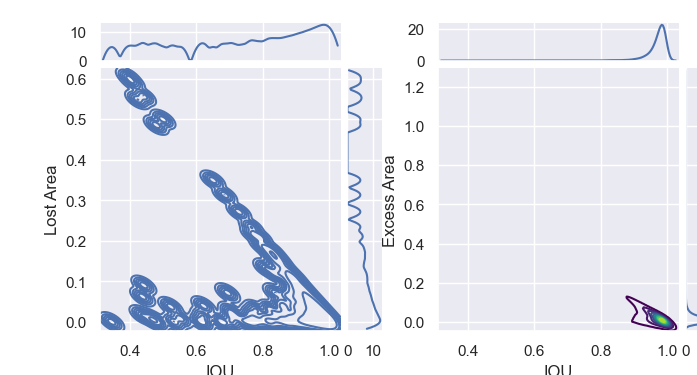

In [36]:
df = pd.DataFrame(dict(
    Attack = np.random.random(20),
    Defense = np.random.random(20)))

#g0 = sns.lmplot(data= df, x='Attack', y= 'Defense') 
#g1 = sns.jointplot(data= df, x='Attack', y= 'Defense', kind='scatter',color='purple') 
g1=sns.jointplot(data=dfe, x="IOU", y="Excess Area", kind="kde", 
                   #marginal_kws=dict(bins=30), bins=30, 
                 cmap='viridis',
                  marginal_ticks=True)
with plot_kde_as_log():
    g0 =sns.jointplot(data=dfl, x="IOU", y="Lost Area", kind="kde", 
                       #marginal_kws=dict(bins=30), bins=30, cmap='viridis',
                      marginal_ticks=True)#, joint_kws={'log_scale':True, 'vmin':1e-3})
#g0.ax_joint.set_cscale('log')

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

#gs.tight_layout(fig)

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

In [38]:
col = MplColorHelper('viridis',0,1)

In [39]:
nsteps = 10000
linlist = col.get_rgb(np.linspace(0,1,nsteps+1))
# log sample
inds = nsteps-np.round(np.logspace(0,np.round(np.log10(nsteps)).astype(int),100)).astype(int)
inds = inds[::-1]
# Create the colormap
cmap_name = 'logvir'
n_bin = 100
mycmap = LinearSegmentedColormap.from_list(cmap_name, linlist[inds], N=n_bin)

In [40]:
mycmap

In [84]:
#imout_name = '1975AJ_____80___93M_p8.jpeg'
imout_name = '1975ApJS___29__397H_p17.jpeg'

In [97]:
#ax1.set_anchor?

Signature: ax1.set_anchor(anchor, share=False)
Docstring:
Define the anchor location.

The actual drawing area (active position) of the Axes may be smaller
than the Bbox (original position) when a fixed aspect is required. The
anchor defines where the drawing area will be located within the
available space.

Parameters
----------
anchor : 2-tuple of floats or {'C', 'SW', 'S', 'SE', ...}
    The anchor position may be either:

    - a sequence (*cx*, *cy*). *cx* and *cy* may range from 0
      to 1, where 0 is left or bottom and 1 is right or top.

    - a string using cardinal directions as abbreviation:

      - 'C' for centered
      - 'S' (south) for bottom-center
      - 'SW' (south west) for bottom-left
      - etc.

      Here is an overview of the possible positions:

      +------+------+------+
      | 'NW' | 'N'  | 'NE' |
      +------+------+------+
      | 'W'  | 'C'  | 'E'  |
      +------+------+------+
      | 'SW' | 'S'  | 'SE' |
      +------+------+------+

share : bo

In [85]:
#sns.jointplot?
from matplotlib.colors import LogNorm, SymLogNorm
from PIL import Image

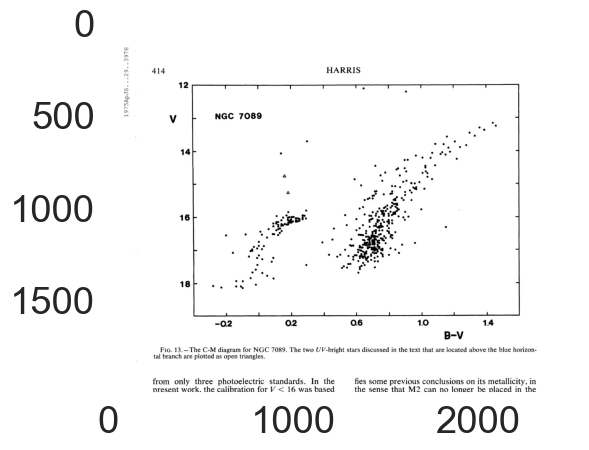

In [130]:
imgIn = np.array(Image.open(config.images_jpeg_dir + imout_name).convert('RGB'))
img = imgIn[0:2000,0:imgIn.shape[1]]
plt.imshow(img)

/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper2/ref_figures/iou_dist_defined_figs_squish2.pdf


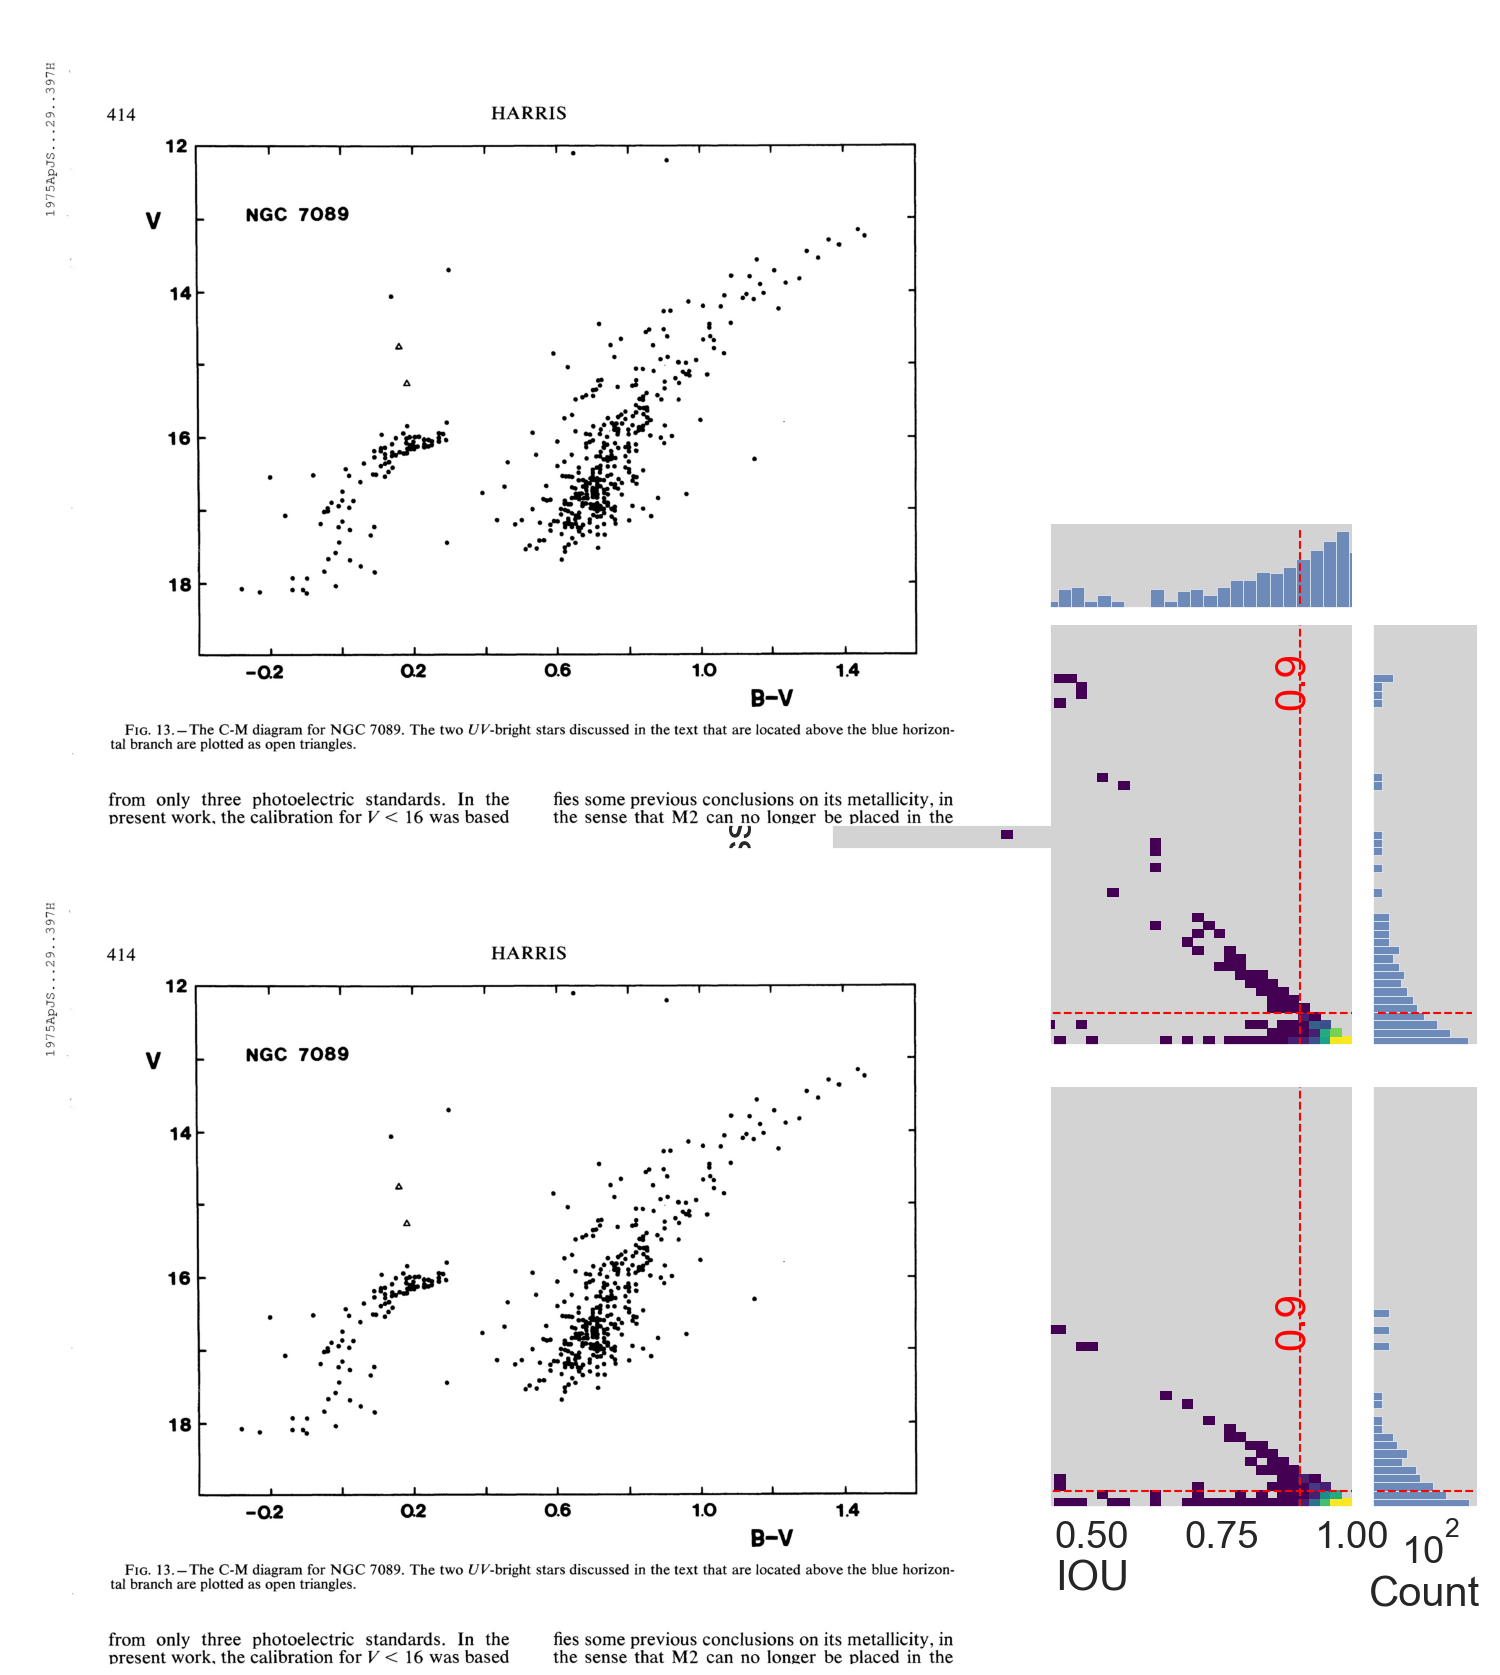

In [157]:
sns.set_style(style='white')
#sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
###font = {'weight':'normal','size'   : 16}
sns.set(rc={'axes.facecolor':'lightgray','axes.grid' : False}, font_scale=2.5)

#lines_text_color = 'limegreen'
lines_text_color = 'red'

#lims = (1.1e1, 3e3)
ratio = 4

# fig excess, fig loss, cap excess, cap loss
yps = [0.10, 0.05, 0.1, 0.05]
# IOUs
xps = [0.9, 0.9, 0.9, 0.9]

nbins = 50
xlims = (0,1)
ylims = (0, 1.25)
#(x_edges, y_edges = bins)
nbins = [np.linspace(xlims[0],xlims[1],nbins), np.linspace(ylims[0],ylims[1],nbins)]


# for drawing squares
w = 0.1; h = 0.2
# xmin, ymin, w, h - true
x1 = 0.05; y1 = 0.9; x2 = x1+w; y2 = y1+h
ctrue = 'magenta'
# xmin, ymin, w, h - found
x1fh = 0.07; y1fh = 0.85; x2fh = x1fh+w; y2fh = y1fh+h
cfound='orange'
# background box
x1b = 0.03; y1b = 0.8; x2b = 0.2; y2b = 1.15
# scales
bx1 = 0.0; bx2 = 1.0; by1 = 0.0; by2 = 1.2
fill_col = 'darkseagreen' # fill in excess/loss regions
linethick_diagram = 5


# -------  excess  -----------
ge = sns.jointplot(data=dfe, x="IOU", y="Excess Area", kind="hist", bins=nbins,
                   marginal_kws=dict(bins=nbins[1]),#, bins=30, 
                   cmap=mycmap,
                  marginal_ticks=True,ratio=ratio)#, norm=LogNorm())

ge.ax_marg_x.set_yscale('log')
ge.ax_marg_y.set_xscale('log')
ge.ax_joint.get_xaxis().set_visible(False)
ge.ax_marg_y.get_xaxis().set_visible(False)
#ge.ax_marg_y.set_xlim(lims)

ge.ax_joint.set_xlim((0,1))
ge.ax_joint.set_ylim((0,1.3))

xp = xps[0]; yp = yps[0]
ge.ax_joint.plot([xp,xp],ge.ax_joint.get_ylim(),'--', color=lines_text_color)
ge.ax_joint.plot(ge.ax_joint.get_xlim(),[yp,yp],'--', color=lines_text_color)
ge.ax_marg_x.plot([xp,xp],ge.ax_marg_x.get_ylim(),'--', color=lines_text_color)
ge.ax_marg_y.plot(ge.ax_marg_y.get_xlim(),[yp,yp],'--', color=lines_text_color)

# where do x/y text live?
y = dfe['Excess Area'].values
ge.ax_joint.text(0.1,yp+0.01*(y.max()-y.min()), str(round(yp*100,2))+'%',color=lines_text_color)
ge.ax_joint.text(xp-0.05, 0.85*(y.max()-y.min()), str(round(xp,3)),color=lines_text_color,rotation=90)

# draw boxes, rescale so same on all plots
# first background
x1bb = (x1b-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(ge.ax_joint.get_xlim()[1]-ge.ax_joint.get_xlim()[0])
x2bb = (x2b-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(ge.ax_joint.get_xlim()[1]-ge.ax_joint.get_xlim()[0])
y1bb = (y1b-ge.ax_joint.get_ylim()[0])/(by2-by1)*(ge.ax_joint.get_ylim()[1]-ge.ax_joint.get_ylim()[0])
y2bb = (y2b-ge.ax_joint.get_ylim()[0])/(by2-by1)*(ge.ax_joint.get_ylim()[1]-ge.ax_joint.get_ylim()[0])
rectb = pt.Rectangle((x1bb, y1bb), x2bb - x1bb, y2bb - y1bb, linewidth=0, edgecolor=None,
                         facecolor='black')
ge.ax_joint.add_patch(rectb)

# true
x1t = (x1-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(ge.ax_joint.get_xlim()[1]-ge.ax_joint.get_xlim()[0])
x2t = (x2-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(ge.ax_joint.get_xlim()[1]-ge.ax_joint.get_xlim()[0])
y1t = (y1-ge.ax_joint.get_ylim()[0])/(by2-by1)*(ge.ax_joint.get_ylim()[1]-ge.ax_joint.get_ylim()[0])
y2t = (y2-ge.ax_joint.get_ylim()[0])/(by2-by1)*(ge.ax_joint.get_ylim()[1]-ge.ax_joint.get_ylim()[0])
# true
x1f = (x1fh-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(ge.ax_joint.get_xlim()[1]-ge.ax_joint.get_xlim()[0])
x2f = (x2fh-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(ge.ax_joint.get_xlim()[1]-ge.ax_joint.get_xlim()[0])
y1f = (y1fh-ge.ax_joint.get_ylim()[0])/(by2-by1)*(ge.ax_joint.get_ylim()[1]-ge.ax_joint.get_ylim()[0])
y2f = (y2fh-ge.ax_joint.get_ylim()[0])/(by2-by1)*(ge.ax_joint.get_ylim()[1]-ge.ax_joint.get_ylim()[0])
# first
x1e = x1f; x2e = x2f
y1e = y1f; y2e = y1t
# then white backgrounds
recttw = pt.Rectangle((x1t, y1t), x2t - x1t, y2t - y1t, linewidth=1, edgecolor=None,
                         facecolor='white')
rectfw = pt.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=1, edgecolor=None,
                         facecolor='white')
ge.ax_joint.add_patch(recttw)
ge.ax_joint.add_patch(rectfw)
recte1 = pt.Rectangle((x1e, y1e), x2e - x1e, y2e - y1e, linewidth=0, edgecolor=None,
                         facecolor=fill_col)
ge.ax_joint.add_patch(recte1)
# second
x1e2 = x2t; x2e2 = x2f
y1e2 = y1f; y2e2 = y2f
recte2 = pt.Rectangle((x1e2, y1e2), x2e2 - x1e2, y2e2 - y1e2, linewidth=0, edgecolor=None,
                         facecolor=fill_col)
ge.ax_joint.add_patch(recte2)
# draw true/found boxes
# then colors on top
rectt = pt.Rectangle((x1t, y1t), x2t - x1t, y2t - y1t, linewidth=linethick_diagram, edgecolor=ctrue,
                         facecolor='none')
ge.ax_joint.add_patch(rectt)
#found
rectf = pt.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=linethick_diagram, edgecolor=cfound,
                         facecolor='none')
ge.ax_joint.add_patch(rectf)
 

# -------  loss  ----------
gl = sns.jointplot(data=dfl, x="IOU", y="Lost Area", kind="hist", bins=nbins,
                   marginal_kws=dict(bins=nbins[1]), #bins=30, 
                   cmap=mycmap,
                  marginal_ticks=True,ratio=ratio)#, cbar=True)

#gl.ax_marg_y.set_yscale('log')
gl.ax_marg_y.set_xscale('log')
#gl.ax_marg_y.set_xlim(lims)

gl.ax_joint.set_xlim((0,1))
gl.ax_joint.set_ylim((0,1.3))

xp = xps[1]; yp = yps[1]
gl.ax_joint.plot([xp,xp],gl.ax_joint.get_ylim(),'--', color=lines_text_color)
gl.ax_joint.plot(gl.ax_joint.get_xlim(),[yp,yp],'--', color=lines_text_color)

# where do x/y text live?
y = dfl['Lost Area'].values
gl.ax_joint.text(0.1,yp+0.01*(y.max()-y.min()), str(round(yp*100,2))+'%',color=lines_text_color)
gl.ax_joint.text(xp-0.05, 0.85*(y.max()-y.min()), str(round(xp,3)),color=lines_text_color,rotation=90)
gl.ax_marg_x.plot([xp,xp],gl.ax_marg_x.get_ylim(),'--', color=lines_text_color)
gl.ax_marg_y.plot(gl.ax_marg_y.get_xlim(),[yp,yp],'--', color=lines_text_color)


# --------- PLACEMENT ------------
base = 8
#fig = plt.figure(figsize=(base*1.1,base*2.1))
fig = plt.figure(figsize=(base*1.3*2,base*2.1))
gs = gridspec.GridSpec(2,2)#,
#         width_ratios=[3,1])#, height_ratios=[1,2]) # 2x2 plots
#    width_ratios=None,
#    height_ratios=None,
gs.update(left=0.1,right=0.8,top=0.965,bottom=-0.075,wspace=0.3,hspace=0.09)
# widths = [2, 3, 1.5]
# heights = [1, 3, 2]
# spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
#                           height_ratios=heights)


mg0 = SeabornFig2Grid(ge, fig, gs[0,1])
mg1 = SeabornFig2Grid(gl, fig, gs[1,1])

# -------- END PLACEMENT ------------

# fake plots
ax1 = plt.subplot(gs[0, 0])
ax1.imshow(img)
#ax1.set_anchor('C')
# # finally, set new location/dimensions of the axes
# ax1.set_position([box1.x0, new_bottom1, w1, new_h1])
# ax2.set_position([box2.x0, box2.y0, w2, new_h2])

# fake plots
ax2 = plt.subplot(gs[1, 0])
ax2.imshow(img)
ax2.set_anchor('C')

for a in [ax1,ax2]:
    a.xaxis.set_visible(False) 
    a.yaxis.set_visible(False) 



# ******** END IMAGES *************


gl.ax_marg_x.set_visible(False) # has to be here for REASONS -- DOES THIS BREAK A THING??
gl.ax_marg_y.set_xlim(ge.ax_marg_y.get_xlim())


# draw boxes, rescale so same on all plots
# first background
x1bb = (x1b-gl.ax_joint.get_xlim()[0])/(bx2-bx1)*(gl.ax_joint.get_xlim()[1]-gl.ax_joint.get_xlim()[0])
x2bb = (x2b-ge.ax_joint.get_xlim()[0])/(bx2-bx1)*(gl.ax_joint.get_xlim()[1]-gl.ax_joint.get_xlim()[0])
y1bb = (y1b-gl.ax_joint.get_ylim()[0])/(by2-by1)*(gl.ax_joint.get_ylim()[1]-gl.ax_joint.get_ylim()[0])
y2bb = (y2b-gl.ax_joint.get_ylim()[0])/(by2-by1)*(gl.ax_joint.get_ylim()[1]-gl.ax_joint.get_ylim()[0])
rectb = pt.Rectangle((x1bb, y1bb), x2bb - x1bb, y2bb - y1bb, linewidth=0, edgecolor=None,
                         facecolor='black')
gl.ax_joint.add_patch(rectb)

# true
x1t = (x1-gl.ax_joint.get_xlim()[0])/(bx2-bx1)*(gl.ax_joint.get_xlim()[1]-gl.ax_joint.get_xlim()[0])
x2t = (x2-gl.ax_joint.get_xlim()[0])/(bx2-bx1)*(gl.ax_joint.get_xlim()[1]-gl.ax_joint.get_xlim()[0])
y1t = (y1-gl.ax_joint.get_ylim()[0])/(by2-by1)*(gl.ax_joint.get_ylim()[1]-gl.ax_joint.get_ylim()[0])
y2t = (y2-gl.ax_joint.get_ylim()[0])/(by2-by1)*(gl.ax_joint.get_ylim()[1]-gl.ax_joint.get_ylim()[0])
# true
x1f = (x1fh-gl.ax_joint.get_xlim()[0])/(bx2-bx1)*(gl.ax_joint.get_xlim()[1]-gl.ax_joint.get_xlim()[0])
x2f = (x2fh-gl.ax_joint.get_xlim()[0])/(bx2-bx1)*(gl.ax_joint.get_xlim()[1]-gl.ax_joint.get_xlim()[0])
y1f = (y1fh-gl.ax_joint.get_ylim()[0])/(by2-by1)*(gl.ax_joint.get_ylim()[1]-gl.ax_joint.get_ylim()[0])
y2f = (y2fh-gl.ax_joint.get_ylim()[0])/(by2-by1)*(gl.ax_joint.get_ylim()[1]-gl.ax_joint.get_ylim()[0])
# first
# x1e = x1f; x2e = x2f
# y1e = y1f; y2e = y1t
# then white backgrounds
recttw = pt.Rectangle((x1t, y1t), x2t - x1t, y2t - y1t, linewidth=1, edgecolor=None,
                         facecolor='white')
rectfw = pt.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=1, edgecolor=None,
                         facecolor='white')
gl.ax_joint.add_patch(recttw)
gl.ax_joint.add_patch(rectfw)

# first
x1e = x1t; x2e = x1f
y1e = y1t; y2e = y2t
recte1 = pt.Rectangle((x1e, y1e), x2e - x1e, y2e - y1e, linewidth=0, edgecolor=None,
                         facecolor=fill_col)
gl.ax_joint.add_patch(recte1)
# second
x1e2 = x1f; x2e2 = x2t
y1e2 = y2f; y2e2 = y2t
recte2 = pt.Rectangle((x1e2, y1e2), x2e2 - x1e2, y2e2 - y1e2, linewidth=0, edgecolor=None,
                         facecolor=fill_col)
gl.ax_joint.add_patch(recte2)
# draw true/found boxes
# then colors on top
rectt = pt.Rectangle((x1t, y1t), x2t - x1t, y2t - y1t, linewidth=linethick_diagram, edgecolor=ctrue,
                         facecolor='none')
gl.ax_joint.add_patch(rectt)
#found
rectf = pt.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=linethick_diagram, edgecolor=cfound,
                         facecolor='none')
gl.ax_joint.add_patch(rectf)

#gs.tight_layout(fig, rect=[-0.05, -0.03, 1, 1]) # for placing fig -- without colorbar
# xmin, ymin, w, h
#gs.tight_layout(fig, rect=[-0.25, -0.03, 1.2, 1.5]) # for placing fig -- without colorbar

# xmin, ymin, w, h
ax1.set_position([0.0,0.5,0.5,0.5])
ax2.set_position([0.0,0.0,0.5,0.5])

width = 0.25 # widht of joint plot
xmin = 0.4 # x start of joint plots
ymin = 0.1 # y start of joint plots
height = 0.25 # height of joint plots
ywidth = 0.05 # width of y-side marginal
yspace = 0.01 # space between y-side marginal and joint
xspace = 0.01 # space between x-side marginal and joint
plots_vert_space = 0.1 # distance between 2 main joint plots
gl.ax_joint.set_position([xmin,ymin,width,height])
gl.ax_marg_y.set_position([xmin+width+yspace, ymin, ywidth, height])

ge.ax_joint.set_position([xmin,ymin+height+plots_vert_space, width, height])
ge.ax_marg_y.set_position([xmin+width+yspace, ymin+height+plots_vert_space, ywidth, height])
ge.ax_marg_x.set_position([xmin, ymin+height*2+plots_vert_space+xspace, width, ywidth])
#fig.set_position([0.5,0.0,0.5,1.0])
#gs.bottom = 0.0


plt.savefig(save_fig_name_base + 'defined_figs_squish2.pdf')#,bbox_inches="tight",pad_inches=0.20)
print(save_fig_name_base + 'defined_figs_squish2.pdf')

In [142]:
gl.ax_joint.set_position

Init signature: SeabornFig2Grid(seaborngrid, fig, subplot_spec)
Docstring:      <no docstring>
Type:           type
Subclasses:     

In [63]:
# cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
# plt.colorbar(cax=cbar_ax)


In [506]:
gl.fig.ad

'C'

In [513]:
figout = gl.ax_joint.get_figure()

In [525]:
gs2=gl.ax_joint.get_gridspec()

In [528]:
gs2.get_grid_positions(fig)

(array([0.48818906, 0.40858329, 0.32897752, 0.24937175, 0.16976597,
        0.0901602 ]),
 array([0.5545272 , 0.47492143, 0.39531566, 0.31570989, 0.23610412,
        0.15649835]),
 array([0.15435123, 0.29081678, 0.42728232, 0.56374787, 0.70021342,
        0.83667896]),
 array([0.26807252, 0.40453807, 0.54100361, 0.67746916, 0.81393471,
        0.95040025]))

In [515]:
figout.bbox_inches

Bbox([[0.0, 0.0], [10.4, 16.8]])

In [298]:
#plt.axes?

0.05
0.72


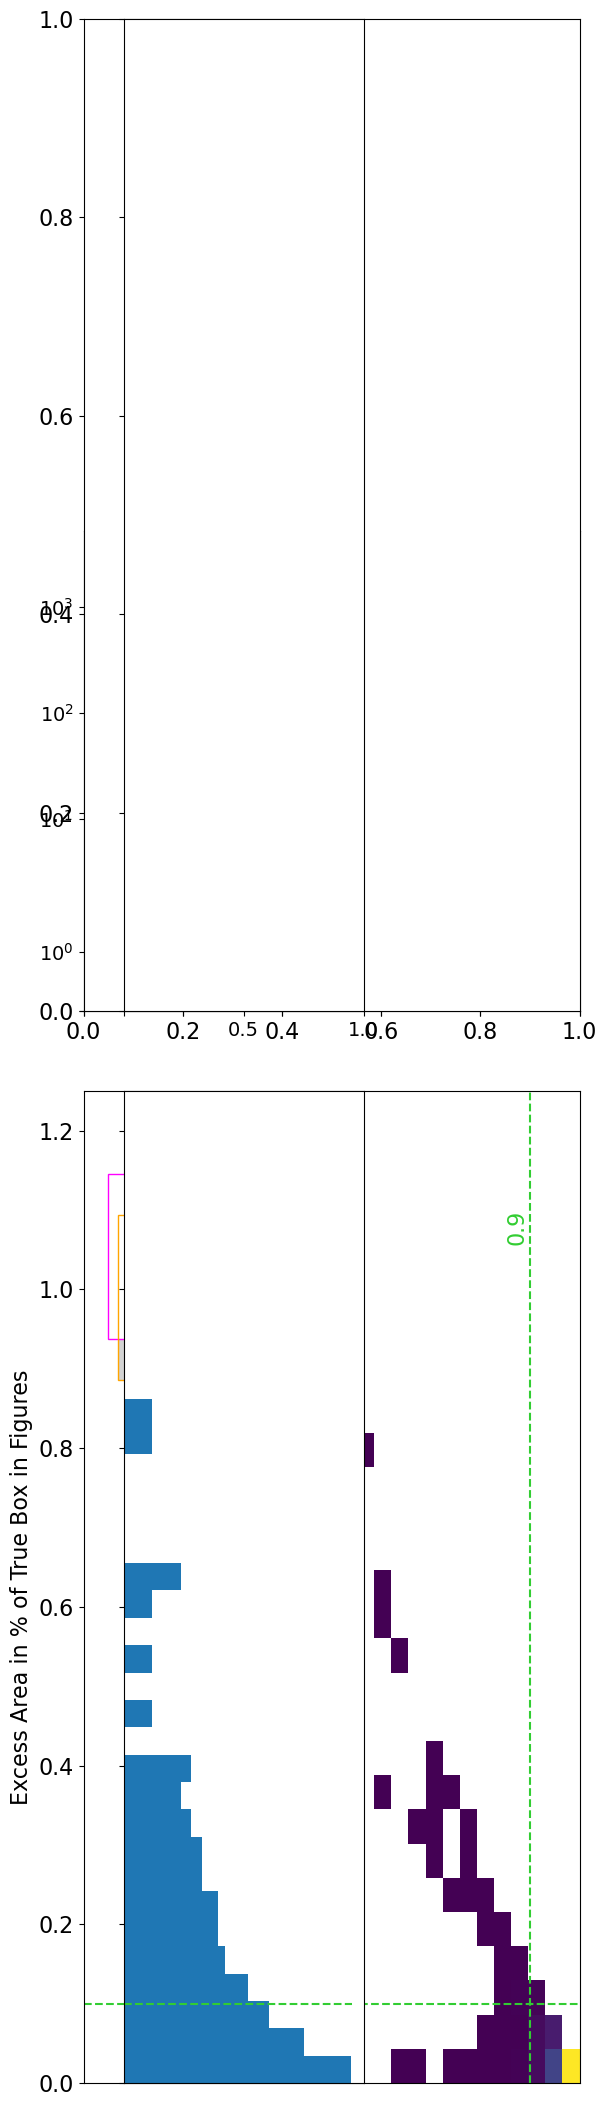

In [296]:
percent_out = 90

font = {'weight':'normal','size'   : 16}
matplotlib.rc('font', **font)
axes_labelsize = 14

# 1x4
nbins = 30

xlims = (0,1)
ylims = (0, 1.25)

#(x_edges, y_edges = bins)
nbins = [np.linspace(xlims[0],xlims[1],nbins), np.linspace(ylims[0],ylims[1],nbins)]

nPlots = 2
# start with a rectangular Figure
sfig = 8
# debug
#sfig=4
fig = plt.figure(1, figsize=(sfig, sfig*nPlots))
nullfmt = NullFormatter()         # no labels

axScatters = []; axHistxs = []; axHistys = []

wall = 0.62
#wall = 0.4

debug = False

for i in range(nPlots):
    # definitions for the axes
    #left, width = 0.1, wall
    #bottom, height = 0.1/nPlots/nPlots+(1-(0.35+wall/nPlots)/nPlots*(i+1))-(0.65-0.35), wall/nPlots
    #left_h = left + width + 0.03
    #bottom_h = bottom + height + 0.03/nPlots
    
    # left/right/height are for the scatter plots
    left, width = 0.1, wall
    height = wall # square
    bottom = height*i + 0.05*(i+1) # little space
    print(bottom)
    
    # on the vertical, only on top - axHistx
    left_hv = left; width_hv = wall
    height_hv = 0.3
    bottom_hv = (bottom + height + 0.05) # little space
    
    # on side
    left_hh = left + 0.05 # little space
    width_hh = 0.3
    height_hh = height
    bottom_hh = bottom
    
    #rect_scatter = [left, bottom, width, height]
    #rect_histy = [left_h, bottom, 0.2, height]
    #rect_histx = [left, bottom_h, width, 0.2/nPlots]
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_hh, bottom_hh, width_hh, height_hh]
    rect_histx = [left_hv, bottom_hv, width_hv, height_hv]
    
    axScatters.append(plt.axes(rect_scatter,label='s'+str(i)))
    axHistys.append(plt.axes(rect_histy,label='y'+str(i)))
    if i==0: #only IOU on top
        axHistxs.append(plt.axes(rect_histx,label='x'+str(i)))
    else:
        axHistxs.append([])
    


xs = []; ys = []; ytits = []
#excess figs
mask = excess_figs > -1
x = ious_figs[mask]; y = excess_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figures')
# loss figs
mask = loss_figs > -1
x = ious_figs[mask]; y = loss_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figures')
#excess caps
mask = excess_caps > -1
x = ious_caps[mask]; y = excess_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figure Captions')
# loss caps
mask = loss_caps > -1
x = ious_caps[mask]; y = loss_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figure Captions')
type_plot = ['excess','loss','excess','loss']

# # calcs
# xps=[]; yps=[]
# for x,y, in zip(xs,ys):
#     yp = np.percentile(y,percent_out)
#     xp = np.percentile(x,100-percent_out)
#     xps.append(xp); yps.append(yp)


w = 0.1; h = 0.2
# xmin, ymin, w, h - true
x1 = 0.05; y1 = 0.9; x2 = x1+w; y2 = y1+h
ctrue = 'magenta'
# xmin, ymin, w, h - found
x1fh = 0.07; y1fh = 0.85; x2fh = x1fh+w; y2fh = y1fh+h
cfound='orange'
# scales
bx1 = 0.0; bx2 = 1.0; by1 = 0.0; by2 = 1.2

#lines_text_color = 'darkolivegreen'
lines_text_color = 'limegreen'


for iplot, (x,y,axScatter,axHistx,axHisty,ytit,xp,yp,tp) in enumerate(zip(xs,ys,axScatters,axHistxs,axHistys,ytits,xps,yps,type_plot)):
    # the scatter plot:
    axScatter.hist2d(x,y, cmap='viridis',cmin=1, bins=nbins)
    #axScatter.set_xlim((x.min(),x.max()))
    axScatter.set_xlim(xlims)
    #axScatter.set_ylim((y.min(),y.max()))
    axScatter.set_ylim(ylims)
    axScatter.set_xlabel('IOU')
    axScatter.set_ylabel(ytit)
    axScatter.plot([xp,xp],axScatter.get_ylim(),'--', color=lines_text_color)
    axScatter.plot(axScatter.get_xlim(),[yp,yp],'--', color=lines_text_color)
    
    # where do x/y text live?
    axScatter.text(0.1,yp+0.01*(y.max()-y.min()), str(round(yp*100,2))+'%',color=lines_text_color)
    axScatter.text(xp-0.05, 0.85*(y.max()-y.min()), str(round(xp,3)),color=lines_text_color,rotation=90)

    # x-side histogram
    if axHistx != []:
        axHistx.hist(x, bins=nbins[1])
        axHistx.plot([xp,xp],axHistx.get_ylim(),'--', color=lines_text_color)
        axHistx.set_xlim(axScatter.get_xlim())
        axHistx.set_yscale('symlog')

    # y-side histogram
    axHisty.hist(y, bins=nbins[0], orientation='horizontal')
    axHisty.plot(axHisty.get_xlim(),[yp,yp],'--', color=lines_text_color)

    axHisty.set_ylim(axScatter.get_ylim())

    axHisty.set_xscale('symlog') # note in this case its x-scale because flipped!
    
    # draw boxes, rescale so same on all plots
    # true
    x1t = (x1-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    x2t = (x2-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    y1t = (y1-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    y2t = (y2-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    # true
    x1f = (x1fh-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    x2f = (x2fh-axScatter.get_xlim()[0])/(bx2-bx1)*(axScatter.get_xlim()[1]-axScatter.get_xlim()[0])
    y1f = (y1fh-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    y2f = (y2fh-axScatter.get_ylim()[0])/(by2-by1)*(axScatter.get_ylim()[1]-axScatter.get_ylim()[0])
    
    # shade excess
    if tp == 'excess':
        # first
        x1e = x1f; x2e = x2f
        y1e = y1f; y2e = y1t
        recte1 = pt.Rectangle((x1e, y1e), x2e - x1e, y2e - y1e, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte1)
        # second
        x1e2 = x2t; x2e2 = x2f
        y1e2 = y1f; y2e2 = y2f
        recte2 = pt.Rectangle((x1e2, y1e2), x2e2 - x1e2, y2e2 - y1e2, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte2)
    else: #loss
        # first
        x1e = x1t; x2e = x1f
        y1e = y1t; y2e = y2t
        recte1 = pt.Rectangle((x1e, y1e), x2e - x1e, y2e - y1e, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte1)
        # second
        x1e2 = x1f; x2e2 = x2t
        y1e2 = y2f; y2e2 = y2t
        recte2 = pt.Rectangle((x1e2, y1e2), x2e2 - x1e2, y2e2 - y1e2, linewidth=0, edgecolor=None,
                                 facecolor='lightgray')
        axScatter.add_patch(recte2)
    
    
    # draw true/found boxes
    rectt = pt.Rectangle((x1t, y1t), x2t - x1t, y2t - y1t, linewidth=1, edgecolor=ctrue,
                             facecolor='none')
    axScatter.add_patch(rectt)
    
    rectf = pt.Rectangle((x1f, y1f), x2f - x1f, y2f - y1f, linewidth=1, edgecolor=cfound,
                             facecolor='none')
    axScatter.add_patch(rectf)
    #break
    


# # no labels
for axHistx in axHistxs:
    if axHistx!=[]:
        axHistx.xaxis.set_major_formatter(nullfmt)
        #axHisty.xaxis.set_minor_locator(plt.MaxNLocator(3))
for axHisty in axHistys:
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    
fig.canvas.draw() # to get tick marks
for axHisty in axHistys:
    # set no 0 for sym log
    yxticks = ['']
    for t in axHisty.get_xticklabels()[1:]:
        #print(t)
        yxticks.append(t.get_text())
    axHisty.set_xticks(axHisty.get_xticks().tolist())
    axHisty.set_xticklabels(yxticks)  
    axHisty.tick_params(axis='both', which='both', labelsize=axes_labelsize)

for axHistx in axHistxs:
    if axHistx!=[]:
        # set no 0 for sym log
        yxticks = ['']
        for t in axHistx.get_yticklabels()[1:]:
            yxticks.append(t.get_text())
        axHistx.set_yticks(axHistx.get_yticks().tolist())
        axHistx.set_yticklabels(yxticks)    
        axHistx.tick_params(axis='both', which='both', labelsize=axes_labelsize)
        

        
for iplot, (x,y,axScatter,axHistx,axHisty,ytit,xp,yp,tp) in enumerate(zip(xs,ys,axScatters,axHistxs,axHistys,ytits,xps,yps,type_plot)):
    # take off top x-axis stuff so that it isn't overwhelming
    if iplot==0:
        axScatter.get_xaxis().set_visible(False)
        axHisty.get_xaxis().set_visible(False)


    
#fig.tight_layout()
fig.savefig(save_fig_name_base + 'defined_figs_squish.pdf')
    
plt.show()

Captions as well:

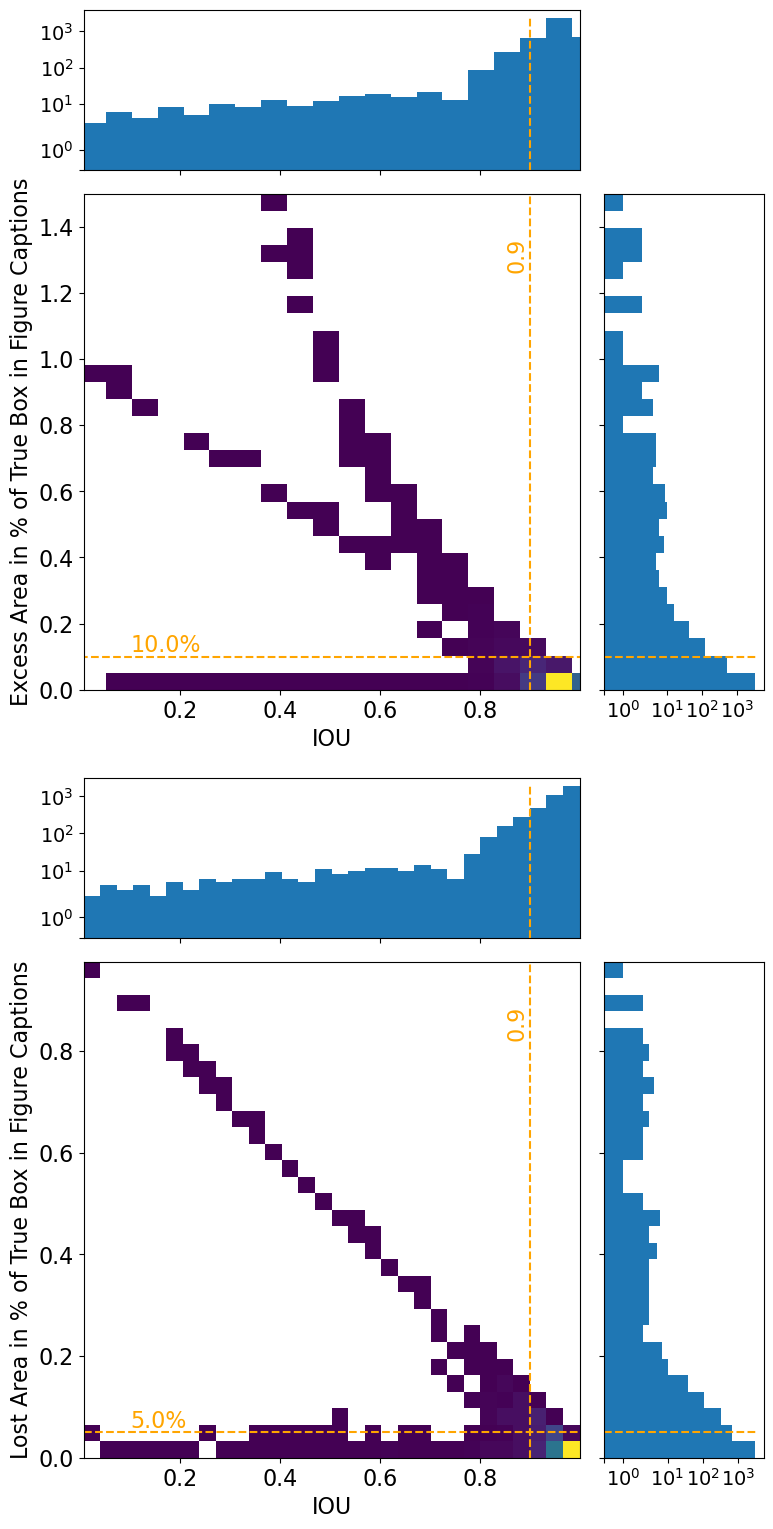

In [202]:
percent_out = 90

font = {'weight':'normal','size'   : 16}
matplotlib.rc('font', **font)
axes_labelsize = 14

# 1x4
nbins = [30,30,np.linspace(0, 1.5, 30), 30]

nPlots = 2
iPlotStart = 2
# start with a rectangular Figure
sfig = 8
# debug
#sfig=4
fig = plt.figure(1, figsize=(sfig, sfig*nPlots))
nullfmt = NullFormatter()         # no labels

axScatters = []; axHistxs = []; axHistys = []

wall = 0.62

debug = False

for i in range(iPlotStart,nPlots+iPlotStart):
    # definitions for the axes
    left, width = 0.1, wall
    bottom, height = 0.1/nPlots/nPlots+(1-(0.65+wall/nPlots)/nPlots*(i+1)), wall/nPlots
    left_h = left + width + 0.03
    bottom_h = bottom + height + 0.03/nPlots
    
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_h, bottom, 0.2, height]
    rect_histx = [left, bottom_h, width, 0.2/nPlots]
    
    axScatters.append(plt.axes(rect_scatter,label='s'+str(i)))
    axHistys.append(plt.axes(rect_histy,label='y'+str(i)))
    axHistxs.append(plt.axes(rect_histx,label='x'+str(i)))

xs = []; ys = []; ytits = []
#excess figs
mask = excess_figs > -1
x = ious_figs[mask]; y = excess_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figures')
# loss figs
mask = loss_figs > -1
x = ious_figs[mask]; y = loss_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figures')
#excess caps
mask = excess_caps > -1
x = ious_caps[mask]; y = excess_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figure Captions')
# loss caps
mask = loss_caps > -1
x = ious_caps[mask]; y = loss_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figure Captions')

    
# fig excess, fig loss, cap excess, cap loss
yps = [0.10, 0.05, 0.1, 0.05]
# IOUs
xps = [0.9, 0.9, 0.9, 0.9]


for x,y,axScatter,\
   axHistx,axHisty,ytit,\
   xp,yp,nbin in zip(xs[iPlotStart:iPlotStart+nPlots],ys[iPlotStart:iPlotStart+nPlots],\
                axScatters,axHistxs,axHistys,ytits[iPlotStart:iPlotStart+nPlots],\
                xps[iPlotStart:iPlotStart+nPlots],yps[iPlotStart:iPlotStart+nPlots],\
                    nbins[iPlotStart:iPlotStart+nPlots]):

    # the scatter plot:
    axScatter.hist2d(x,y, cmap='viridis',cmin=1, bins=nbin)
    axScatter.plot([xp,xp],axScatter.get_ylim(),'--', color='orange')
    axScatter.plot(axScatter.get_xlim(),[yp,yp],'--', color='orange')

    if type(nbin)!=int: # have specific bins
        axScatter.set_xlim((x.min(),x.max()))
        axScatter.set_ylim((nbin.min(),nbin.max()))
        axScatter.text(0.1,yp+0.01*(nbin.max()-nbin.min()), str(round(yp*100,2))+'%',color='orange')
        axScatter.text(xp-0.05, 0.85*(nbin.max()-nbin.min()), str(round(xp,3)),color='orange',rotation=90)
    else:
        axScatter.set_xlim((x.min(),x.max()))
        axScatter.set_ylim((y.min(),y.max()))
        axScatter.text(0.1,yp+0.01*(y.max()-y.min()), str(round(yp*100,2))+'%',color='orange')
        axScatter.text(xp-0.05, 0.85*(y.max()-y.min()), str(round(xp,3)),color='orange',rotation=90)
    axScatter.set_xlabel('IOU')
    axScatter.set_ylabel(ytit)
    

    # x-side histogram
    axHistx.hist(x, bins=nbin)
    axHistx.plot([xp,xp],axHistx.get_ylim(),'--', color='orange')

    # y-side histogram
    axHisty.hist(y, bins=nbin, orientation='horizontal')
    axHisty.plot(axHisty.get_xlim(),[yp,yp],'--', color='orange')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_yscale('symlog')
    axHisty.set_xscale('symlog') # note in this case its x-scale because flipped!
    



# # no labels
for axHistx in axHistxs:
    axHistx.xaxis.set_major_formatter(nullfmt)
    #axHisty.xaxis.set_minor_locator(plt.MaxNLocator(3))
for axHisty in axHistys:
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    
fig.canvas.draw() # to get tick marks
for axHisty in axHistys:
    # set no 0 for sym log
    yxticks = ['']
    for t in axHisty.get_xticklabels()[1:]:
        #print(t)
        yxticks.append(t.get_text())
    axHisty.set_xticks(axHisty.get_xticks().tolist())
    axHisty.set_xticklabels(yxticks)  
    axHisty.tick_params(axis='both', which='both', labelsize=axes_labelsize)

for axHistx in axHistxs:
    # set no 0 for sym log
    yxticks = ['']
    for t in axHistx.get_yticklabels()[1:]:
        yxticks.append(t.get_text())
    axHistx.set_yticks(axHistx.get_yticks().tolist())
    axHistx.set_yticklabels(yxticks)    
    axHistx.tick_params(axis='both', which='both', labelsize=axes_labelsize)

    
#fig.tight_layout()
fig.savefig(save_fig_name_base + 'defined_caps.pdf')
    
plt.show()

In [181]:
x[iPlotStart:iPlotStart+nPlots]

array([0.9755295 , 0.95635363])

In [182]:
y[iPlotStart:iPlotStart+nPlots]

array([0.0029012 , 0.00056456])

In [183]:
ytit[iPlotStart:iPlotStart+nPlots]

'st'

In [184]:
ytit

'Lost Area in % of True Box in Figures'

## Plotting excess/loss with an arbitrary IOU cut-off

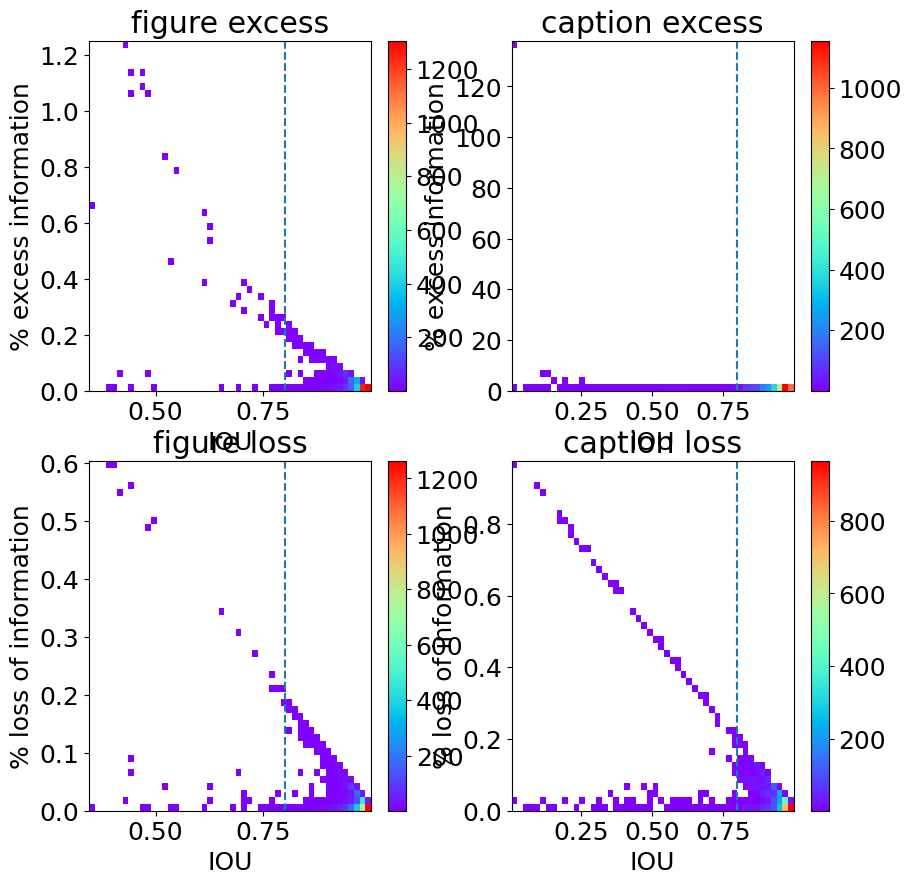

In [33]:
iou_choice = 0.8

# what percent of area in found box is outside when true box is inside found box?
fig, ax = plt.subplots(2,2,figsize=(10,10))

nbins = 50

mask = excess_figs > -1 # fig has some excess
h=ax[0][0].hist2d(ious_figs[mask], excess_figs[mask], cmap='rainbow',cmin=1, bins=nbins)#, weights=weights)
ax[0][0].set_title('figure excess')
ax[0][0].set_xlabel('IOU')
ax[0][0].set_ylabel('% excess information')
ax[0][0].plot([iou_choice,iou_choice],[excess_figs[mask].min(),excess_figs[mask].max()], '--')
fig.colorbar(h[3], ax=ax[0][0])

mask = excess_caps > -1
h=ax[0][1].hist2d(ious_caps[mask], excess_caps[mask], cmap='rainbow',cmin=1, bins=nbins)#, weights=weights)
ax[0][1].set_title('caption excess')
ax[0][1].set_xlabel('IOU')
ax[0][1].set_ylabel('% excess information')
ax[0][1].plot([iou_choice,iou_choice],[excess_caps[mask].min(),excess_caps[mask].max()], '--')
fig.colorbar(h[3], ax=ax[0][1])


mask = loss_figs > -1
h=ax[1][0].hist2d(ious_figs[mask], loss_figs[mask], cmap='rainbow',cmin=1, bins=nbins)#, weights=weights)
ax[1][0].set_title('figure loss')
ax[1][0].set_xlabel('IOU')
ax[1][0].set_ylabel('% loss of information')
ax[1][0].plot([iou_choice,iou_choice],[loss_figs[mask].min(),loss_figs[mask].max()], '--')
fig.colorbar(h[3], ax=ax[1][0])

mask = loss_caps > -1
h=ax[1][1].hist2d(ious_caps[mask], loss_caps[mask], cmap='rainbow',cmin=1, bins=nbins)#, weights=weights)
ax[1][1].set_title('caption loss')
ax[1][1].set_xlabel('IOU')
ax[1][1].set_ylabel('% loss of information')
ax[1][1].plot([iou_choice,iou_choice],[loss_caps[mask].min(),loss_caps[mask].max()], '--')
fig.colorbar(h[3], ax=ax[1][1])

plt.show()

In [19]:
#from scipy.stats import gaussian_kde
# density = gaussian_kde(data)
# xs = np.linspace(0,8,200)
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# plt.plot(xs,density(xs))
# plt.show()

## A different question -- where does 90% of the distribution live?

Below is answering a slightly different question -- where is the 90%-percentile of excess/loss and the 90%-percentile of IOU.

This then looks for the intersection of that value.

In [20]:
percentage = 10 # quartiles

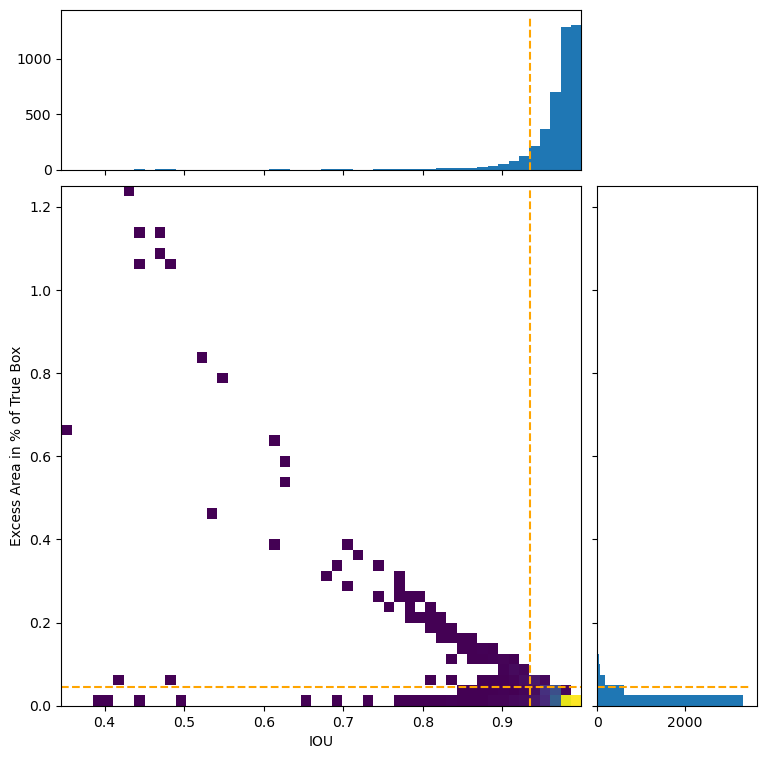

In [23]:
nbins = 50

mask = excess_figs > -1
x = ious_figs[mask]; y = excess_figs[mask]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

yp = np.percentile(y,90)
xp = np.percentile(x,10)

# the scatter plot:
axScatter.hist2d(x,y, cmap='viridis',cmin=1, bins=nbins)
axScatter.plot([xp,xp],axScatter.get_ylim(),'--', color='orange')
axScatter.plot(axScatter.get_xlim(),[yp,yp],'--', color='orange')

axScatter.set_xlim((x.min(),x.max()))
axScatter.set_ylim((y.min(),y.max()))
axScatter.set_xlabel('IOU')
axScatter.set_ylabel('Excess Area in % of True Box')

axHistx.hist(x, bins=nbins)
axHistx.plot([xp,xp],axHistx.get_ylim(),'--', color='orange')

axHisty.hist(y, bins=nbins, orientation='horizontal')
axHisty.plot(axHisty.get_xlim(),[yp,yp],'--', color='orange')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()

In [26]:
#font = {'weight' : 'bold',
#        'size'   : 22}
font = {'weight':'normal','size'   : 18}

matplotlib.rc('font', **font)

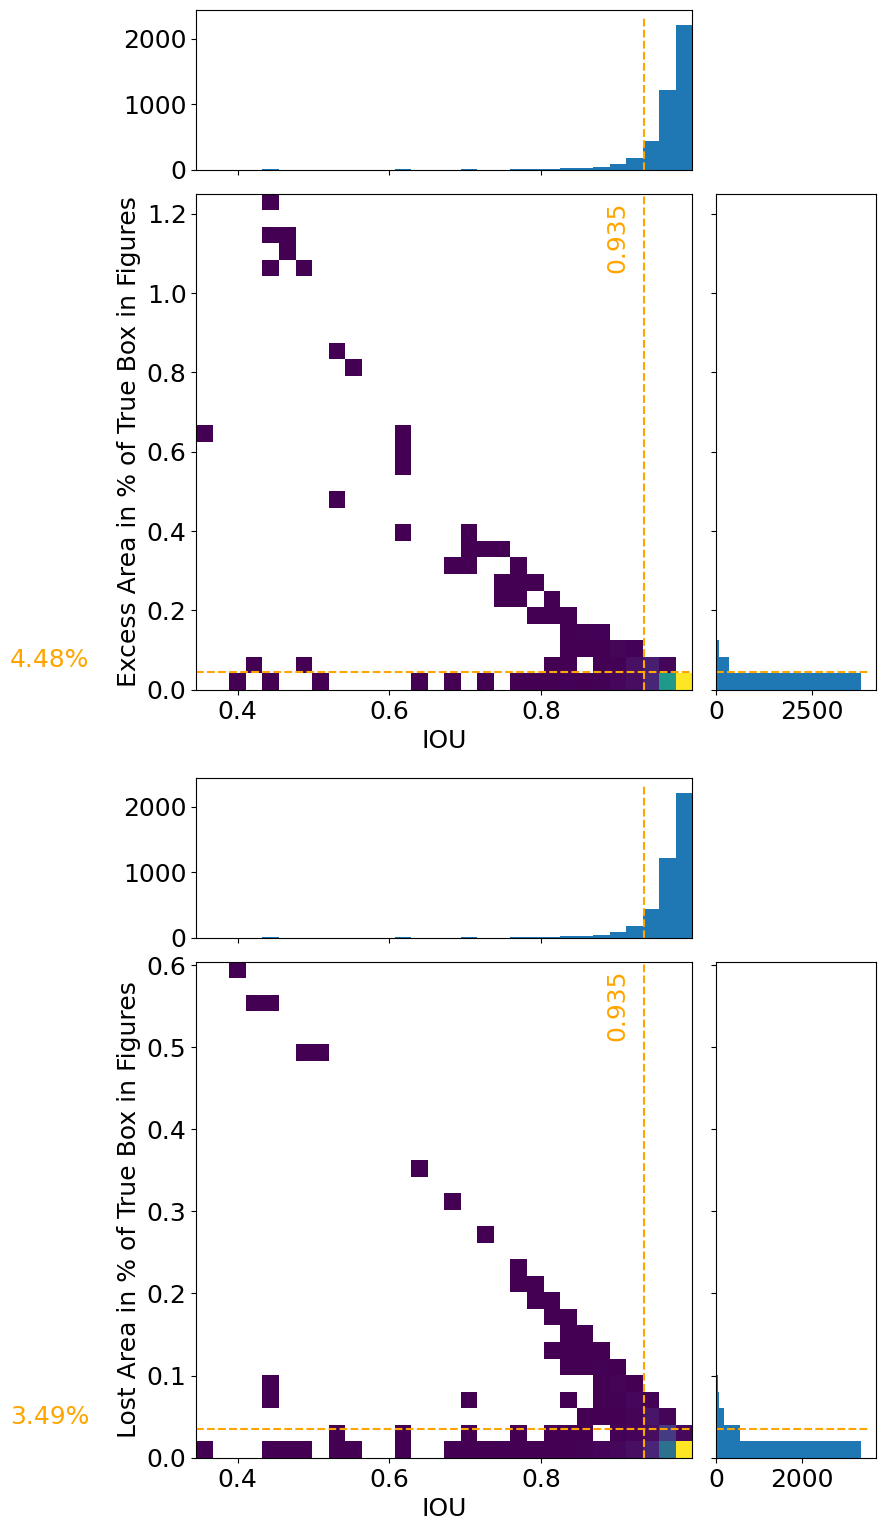

In [32]:
percent_out = 90

# 1x4
nbins = 30

nPlots = 2
# start with a rectangular Figure
fig = plt.figure(1, figsize=(8, 8*nPlots))
nullfmt = NullFormatter()         # no labels

axScatters = []; axHistxs = []; axHistys = []

wall = 0.62

debug = False

for i in range(nPlots):
    # definitions for the axes
    left, width = 0.1, wall
    #bottom, height = 0.1+(1-(0.65+wall/nPlots)/nPlots*(i+1)), wall/nPlots
    bottom, height = 0.1/nPlots/nPlots+(1-(0.65+wall/nPlots)/nPlots*(i+1)), wall/nPlots
    #bottom, height = bottoms[i], wall/nPlots
    #bottom_h = left_h = left + width + 0.02
    left_h = left + width + 0.03
    #bottom_h = bottom + height + 0.02
    bottom_h = bottom + height + 0.03/nPlots
    
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_h, bottom, 0.2, height]
    rect_histx = [left, bottom_h, width, 0.2/nPlots]
    #print(rect_scatter)
    
    axScatters.append(plt.axes(rect_scatter,label='s'+str(i)))
    axHistys.append(plt.axes(rect_histy,label='y'+str(i)))
    axHistxs.append(plt.axes(rect_histx,label='x'+str(i)))
    
    
# # no labels
for axHistx in axHistxs:
    axHistx.xaxis.set_major_formatter(nullfmt)
for axHisty in axHistys:
    axHisty.yaxis.set_major_formatter(nullfmt)


xs = []; ys = []; ytits = []
#excess figs
mask = excess_figs > -1
x = ious_figs[mask]; y = excess_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figures')
# loss figs
mask = loss_figs > -1
x = ious_figs[mask]; y = loss_figs[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figures')
#excess caps
mask = excess_caps > -1
x = ious_caps[mask]; y = excess_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Excess Area in % of True Box in Figure Captions')
# loss caps
mask = loss_caps > -1
x = ious_caps[mask]; y = loss_caps[mask]
xs.append(x.copy()); ys.append(y.copy()); ytits.append('Lost Area in % of True Box in Figure Captions')
    
# calcs
xps=[]; yps=[]
for x,y, in zip(xs,ys):
    yp = np.percentile(y,percent_out)
    xp = np.percentile(x,100-percent_out)
    xps.append(xp); yps.append(yp)


for x,y,axScatter,axHistx,axHisty,ytit in zip(xs,ys,axScatters,axHistxs,axHistys,ytits):
    yp = np.percentile(y,percent_out)
    xp = np.percentile(x,100-percent_out)

    # the scatter plot:
    axScatter.hist2d(x,y, cmap='viridis',cmin=1, bins=nbins)
    axScatter.plot([xp,xp],axScatter.get_ylim(),'--', color='orange')
    axScatter.plot(axScatter.get_xlim(),[yp,yp],'--', color='orange')

    axScatter.set_xlim((x.min(),x.max()))
    axScatter.set_ylim((y.min(),y.max()))
    axScatter.set_xlabel('IOU')
    axScatter.set_ylabel(ytit)
    
    axScatter.text(0.1,yp+0.01*(y.max()-y.min()), str(round(yp*100,2))+'%',color='orange')
    axScatter.text(xp-0.05, 0.85*(y.max()-y.min()), str(round(xp,3)),color='orange',rotation=90)

    axHistx.hist(x, bins=nbins)
    axHistx.plot([xp,xp],axHistx.get_ylim(),'--', color='orange')

    axHisty.hist(y, bins=nbins, orientation='horizontal')
    axHisty.plot(axHisty.get_xlim(),[yp,yp],'--', color='orange')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
#fig.tight_layout()
fig.savefig(save_fig_name + '.pdf')
    
plt.show()

In [344]:
qurt = 10
for x,y,ytit in zip(xs,ys,ytits):
    yp = np.percentile(y,100-qurt)
    xp = np.percentile(x,qurt)
    print(ytit,len(x[x>xp]),'iou',len(y[y<yp]))

Excess Area in % of True Box in Figures 4089 iou 4089
Lost Area in % of True Box in Figures 4089 iou 4089
Excess Area in % of True Box in Figure Captions 4005 iou 12
Lost Area in % of True Box in Figure Captions 4005 iou 0


### Another way of doing this figure based on % levels

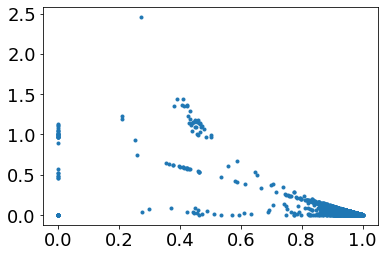

In [347]:
plt.plot(ious_figs, excess_figs, '.')

What is the IOU such that 90% of points have 10% or less of excess?

In [393]:
per_cut = 0.15
per_tot = 0.9

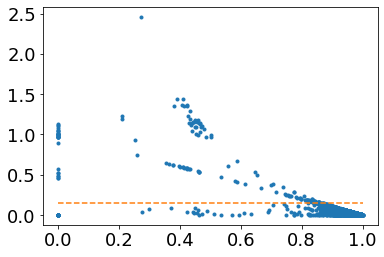

In [394]:
plt.plot(ious_figs, excess_figs, '.')
plt.plot([0,1.0],[per_cut,per_cut],'--')
plt.show()

In [395]:
ious_figs_cut = ious_figs.copy()[excess_figs <= per_cut]

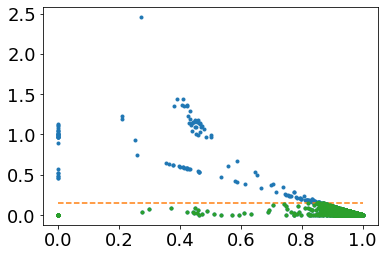

In [396]:
plt.plot(ious_figs, excess_figs, '.')
plt.plot([0,1.0],[per_cut,per_cut],'--')
plt.plot(ious_figs_cut, excess_figs[excess_figs<= per_cut], '.')
plt.show()

In [397]:
yp = np.percentile(ious_figs_cut,5)
yp

0.8898403280798498

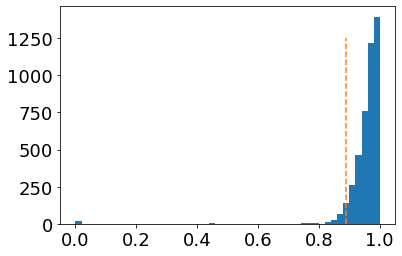

In [398]:
plt.hist(ious_figs_cut,bins=50)
plt.plot([yp,yp],[0,1250],'--')
plt.show()

The line is showing now the IOU cutoff of where 95% of the IOU's within excesses of 10% or less live.

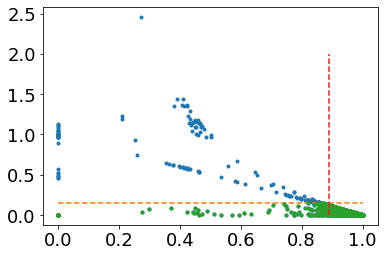

In [399]:
plt.plot(ious_figs, excess_figs, '.')
plt.plot([0,1.0],[per_cut,per_cut],'--')
plt.plot(ious_figs_cut, excess_figs[excess_figs<= per_cut], '.')
plt.plot([yp,yp],[0,2.0],'--')
plt.show()

In [405]:
len(ious_figs_cut[ious_figs_cut>=yp])/len(ious_figs_cut)

0.949943117178612

In [401]:
per_cut_loss = 0.05

In [402]:
ious_figs_loss = ious_figs.copy()[loss_figs <= per_cut_loss]

In [403]:
lyp = np.percentile(ious_figs_loss,5)
lyp

0.8831599623878953

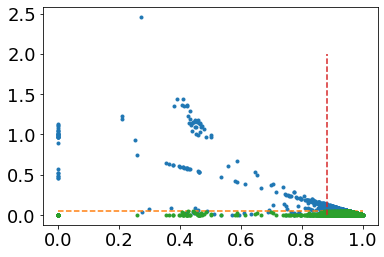

In [404]:
plt.plot(ious_figs, excess_figs, '.')
plt.plot([0,1.0],[per_cut_loss,per_cut_loss],'--')
plt.plot(ious_figs_loss, loss_figs[loss_figs<= per_cut_loss], '.')
plt.plot([lyp,lyp],[0,2.0],'--')
plt.show()

### End main fig generation here?

In [339]:
np.unique(ious_caps)

array([0.        , 0.10446985, 0.11111111, ..., 1.        , 1.        ,
       1.        ])

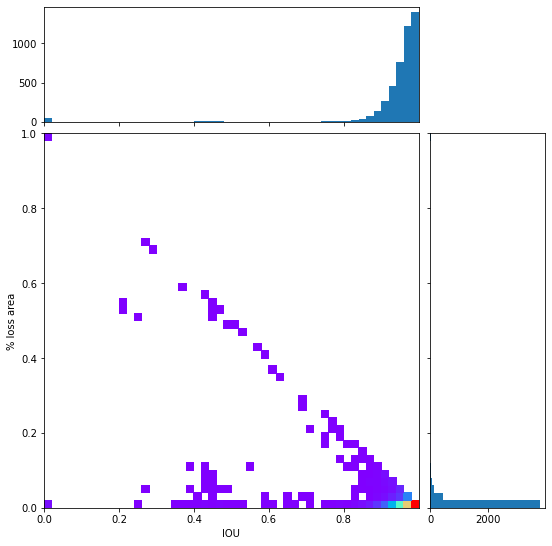

0.03192342479245315


In [259]:
nbins = 50

mask = loss_figs > -1
x = ious_figs[mask]; y = loss_figs[mask]
lablab = 'loss'

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
#axScatter.scatter(x, y)
axScatter.hist2d(x,y, cmap='rainbow',cmin=1, bins=nbins)


# # now determine nice limits by hand:
# binwidth = 0.25
# xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
# lim = (int(xymax/binwidth) + 0) * binwidth

axScatter.set_xlim((x.min(),x.max()))
axScatter.set_ylim((y.min(),y.max()))
axScatter.set_xlabel('IOU')
axScatter.set_ylabel('% '+lablab+' area')




#xhist,xedges = np.histogram(x,bins=nbins)
#x_centers = (xedges[:-1] + xedges[1:])*0.5
#axHistx.bar(x_centers,xhist/len(x),width=(xedges[1] - xedges[0]))
axHistx.hist(x, bins=nbins)
# based on central image
axHistx.set_xlim(axScatter.get_xlim())
#p = pd.DataFrame({'iou':x})
#p.plot(kind='kde',ax=axHistx)


axHisty.hist(y, bins=nbins, orientation='horizontal')
axHisty.set_ylim(axScatter.get_ylim())
#axHisty.set_xscale('log')

plt.show()

print(np.percentile(loss_figs[mask],90))

In [260]:
np.percentile(x,20)

0.9298238506278185

In [261]:
np.percentile(x,10)

0.9007915931102555

In [262]:
x

array([0.89387038, 0.98132252, 0.97600854, ..., 0.97550224, 0.94573035,
       0.98920603])

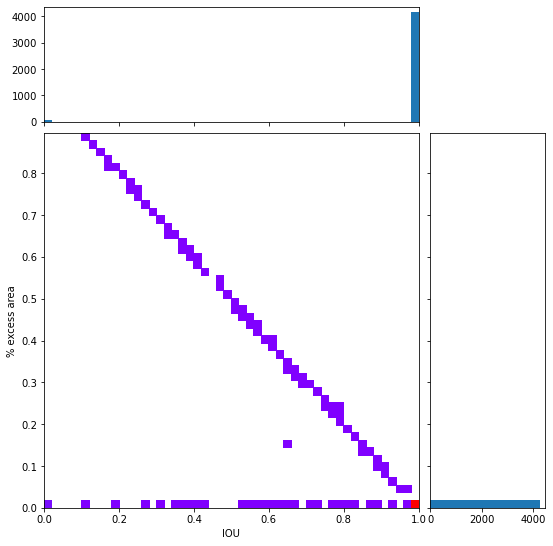

In [263]:
nbins = 50

mask = excess_caps > -1
x = ious_caps[mask]; y = excess_caps[mask]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
#axScatter.scatter(x, y)
axScatter.hist2d(x,y, cmap='rainbow',cmin=1, bins=nbins)


# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 0) * binwidth

#lim_top = (x.min(),x.max())
#axScatter.set_xlim((-lim, lim))
#axScatter.set_ylim((-lim, lim))
axScatter.set_xlim((x.min(),x.max()))
axScatter.set_ylim((y.min(),y.max()))
axScatter.set_xlabel('IOU')
axScatter.set_ylabel('% excess area')

axHistx.hist(x, bins=nbins)
#axHistx.plot(xs_x,density_x(xs_x))


axHisty.hist(y, bins=nbins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()

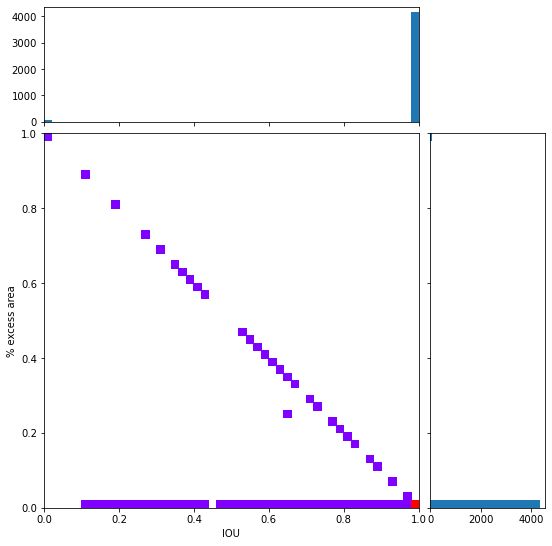

In [264]:
nbins = 50

mask = loss_caps > -1
x = ious_caps[mask]; y = loss_caps[mask]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
#axScatter.scatter(x, y)
axScatter.hist2d(x,y, cmap='rainbow',cmin=1, bins=nbins)


# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 0) * binwidth

axScatter.set_xlim((x.min(),x.max()))
axScatter.set_ylim((y.min(),y.max()))
axScatter.set_xlabel('IOU')
axScatter.set_ylabel('% excess area')

axHistx.hist(x, bins=nbins)
#axHistx.plot(xs_x,density_x(xs_x))

axHisty.hist(y, bins=nbins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
data = [1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
density = gaussian_kde(data)
xs = np.linspace(0,8,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

In [124]:
#import seaborn as sns

In [125]:
#penguins = sns.load_dataset("penguins")

In [142]:
#penguins.head()

In [141]:
#len(ious_caps[maskc]), len(excess_caps[maskc])

In [137]:
# # dfd = {'iou_figs':ious_figs, 'iou_caps':ious_caps, 
# #       'excess_figs':excess_figs, 'excess_caps':excess_caps,
# #       'loss_figs':loss_figs, 'loss_caps':loss_caps}

# mask = excess_figs > -1
# maskc = excess_caps > -1
# dfd1 = {'iou_figs_excess':ious_figs[mask], 'excess_figs':excess_figs[mask]}
# df1 = pd.DataFrame(dfd1)

# dfd2 = { 'iou_caps_excess':ious_caps[maskc], 'excess_caps':excess_caps[maskc]}
# df2 = pd.DataFrame(dfd2)

/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


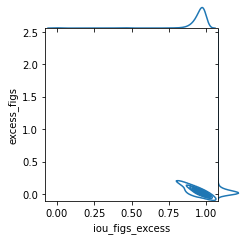

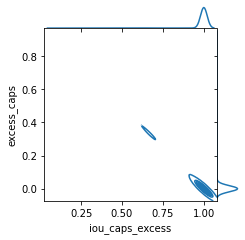

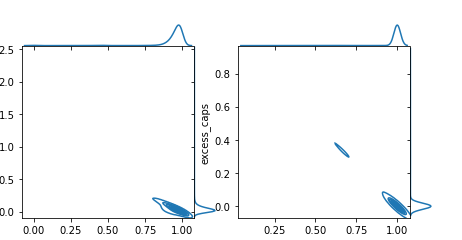

In [140]:
# # fig, ax = plt.subplots(2,2,figsize=(10,10))
# # sns.jointplot(
# #     data=df,
# #     x="iou_figs_excess", y="excess_figs",
# #     kind="kde", ax=ax[0][0]
# # )
# JG1 = sns.jointplot("iou_figs_excess", "excess_figs", data=df1, kind='kde')
# JG2 = sns.jointplot("iou_caps_excess", "excess_caps", data=df2, kind='kde')

# #subplots migration
# f = plt.figure()
# for J in [JG1, JG2]:
#     for A in J.fig.axes:
#         f._axstack.add(f._make_key(A), A)

# #subplots size adjustment
# f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
# f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
# f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
# f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
# f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
# f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])

# plt.show()

In [302]:
ious_figs = np.array(ious_figs)
len(ious_figs[ious_figs<=-1])

545

In [303]:
ious_caps = np.array(ious_caps)
len(ious_caps[ious_caps<=-1])

515

In [305]:
# count not fully covered
covered_figs = []; covered_caps = []; covered_tabs = []; covered_math = []
area_figs = []; area_caps = []; area_tabs = []; area_math = []
names_figs = []
grace = 0 # number of "grace pixels"
for ii,(ff,tt,fn,iall) in enumerate(zip(founds,trues,fnames,ious_all)):
    # sort found by xmin then ymin
    f2 = []; t2 = []; f3 = []
    f2 = np.array(ff[0])
    if len(f2) > 0:
        linds = np.lexsort((f2[:,1],f2[:,2]))
        f2 = f2[linds]
        f3 = np.array(ff[1])[linds]
    # sort trues by xmin then ymin
    t2 = np.array(tt)
    if len(t2) > 0:
        tinds = np.lexsort((t2[:,1],t2[:,2]))
        t2 = t2[tinds]
    for f,t,lf,io in zip(f2,t2,f3,iall):
        lt=-1
        covered = -2
        if len(f) > 0:
            x1min,y1min,x1max,y1max = f
        if len(t) > 0:
            x2min,y2min,x2max,y2max,lt = t
            
        if len(f) > 0 and len(t)>0 and lf == lt-1:
            iouind = int(lt-1)
            # is true inside found?
            if x1min-grace<=x2min and y1min-grace<=y2min and \
               y1max+grace >= y2max and x1max+grace >= x2max:
                covered = 1
                # by how much?
                a1 = ((x1max+grace)-(x1min-grace))*((y1max+grace)-(y1min-grace))
                a2 = (x2max-x2min)*(y2max-y2min)
                area = -(a1-a2)/a1 # function of found, make negative for found
            else: # not covered
                covered = 0
                # figure out how much overlap
                if io[0] > 0:
                    a2 = (x2max-x2min)*(y2max-y2min)
                    a1 = (x1max-x1min)*(y1max-y1min)
                    #area = (a2+a1-io[1])/(a2+a1)
                    area = (a1-io[1])/a1
                else:
                    area = 1.0
                if area == 0: area = 0.0005 # just for tracking
        # otherwise, gone wrong
        elif len(f) > 0 and len(t) == 0:
            covered = 0
            iouind = int(lf)
            area = 1.0
        elif len(f) == 0 and len(t) > 0:
            covered = 0
            iouind = int(lt-1)
            area = 1.0
        elif lf != lt-1:
            covered = 0
            iouind = int(lt-1)
            area = 1.0

        if covered > -2: 
            if LABELS.index('figure') == iouind:
                covered_figs.append(covered)
                names_figs.append(fn)
                area_figs.append(area)
            elif LABELS.index('figure caption') == iouind:
                covered_caps.append(covered)
                area_caps.append(area)
            elif LABELS.index('table') == iouind:
                covered_tabs.append(covered)
                area_tabs.append(area)
            elif LABELS.index('math formula') == iouind:
                covered_math.append(covered)
                area_math.append(area)

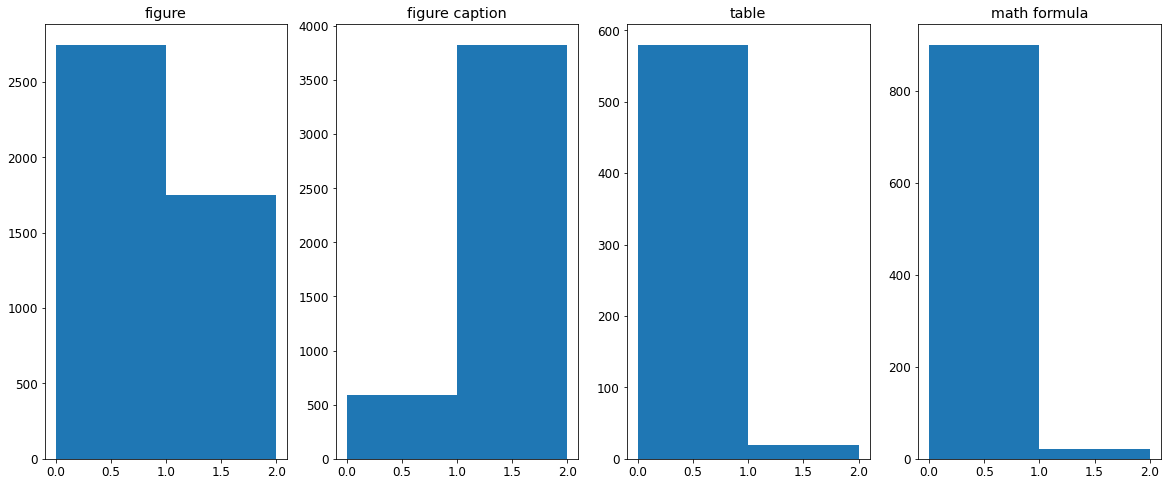

In [306]:
fig, ax = plt.subplots(1,4,figsize=(20,8))
bins = [0,1,2]

ax[0].hist(covered_figs, bins=bins)
ax[0].set_title('figure')

ax[1].hist(covered_caps, bins=bins)
ax[1].set_title('figure caption')

ax[2].hist(covered_tabs, bins=bins)
ax[2].set_title('table')

ax[3].hist(covered_math, bins=bins)
ax[3].set_title('math formula')

plt.show()

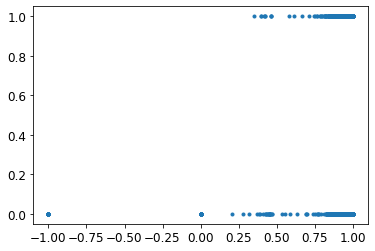

In [307]:
plt.plot(ious_figs,covered_figs,'.')

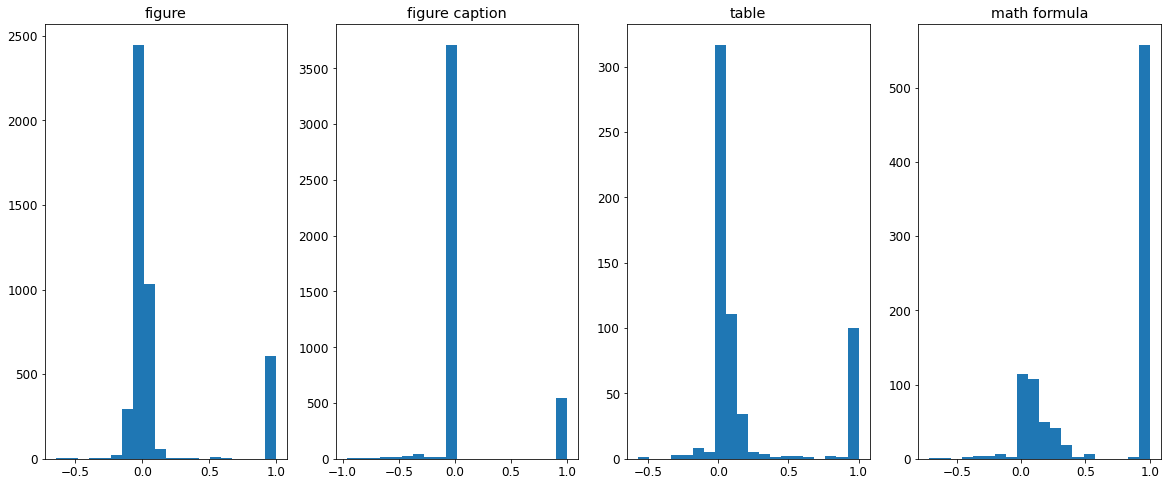

In [308]:
fig, ax = plt.subplots(1,4,figsize=(20,8))
bins = 20

ax[0].hist(area_figs, bins=bins)
ax[0].set_title('figure')

ax[1].hist(area_caps, bins=bins)
ax[1].set_title('figure caption')

ax[2].hist(area_tabs, bins=bins)
ax[2].set_title('table')

ax[3].hist(area_math, bins=bins)
ax[3].set_title('math formula')

plt.show()

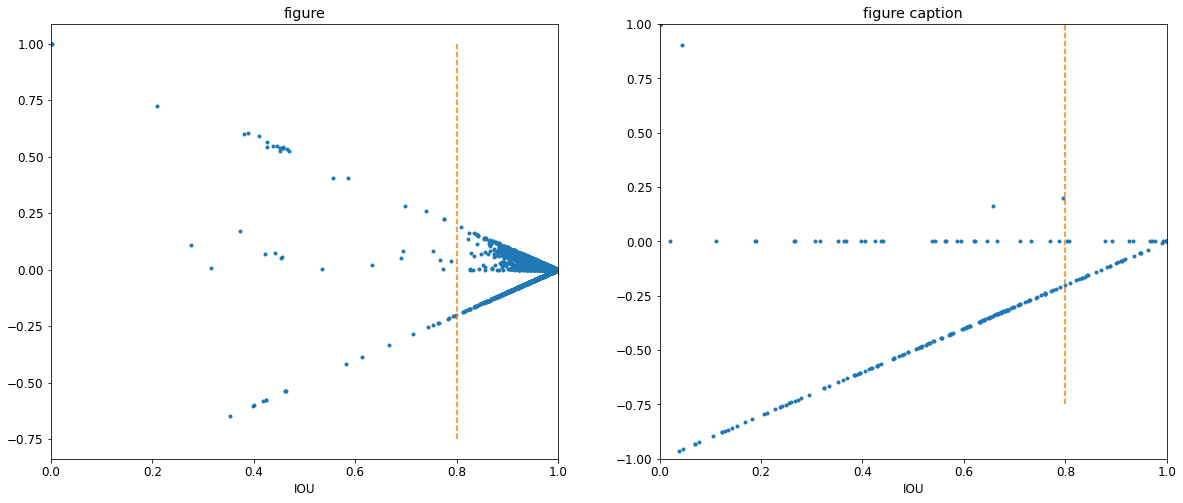

In [309]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(ious_figs, area_figs, '.')
ax[0].set_title('figure')
ax[0].set_xlabel('IOU')
ax[0].set_xlim(0.0,1.0)
ax[0].plot([0.8,0.8],[-0.75,1.0], '--')

ax[1].plot(ious_caps, area_caps, '.')
ax[1].set_title('figure caption')
ax[1].set_xlabel('IOU')
ax[1].set_xlim(0.0,1.0)
ax[1].set_ylim(-1,1)
ax[1].plot([0.8,0.8],[-0.75,1.0], '--')

# ax[1].hist(area_caps, bins=bins)
# ax[1].set_title('figure caption')

# ax[2].hist(area_tabs, bins=bins)
# ax[2].set_title('table')

# ax[3].hist(area_math, bins=bins)
# ax[3].set_title('math formula')

plt.show()

In [310]:
area_figs = np.array(area_figs)
area_caps = np.array(area_caps)
ious_figs = np.array(ious_figs)
ious_caps = np.array(ious_caps)

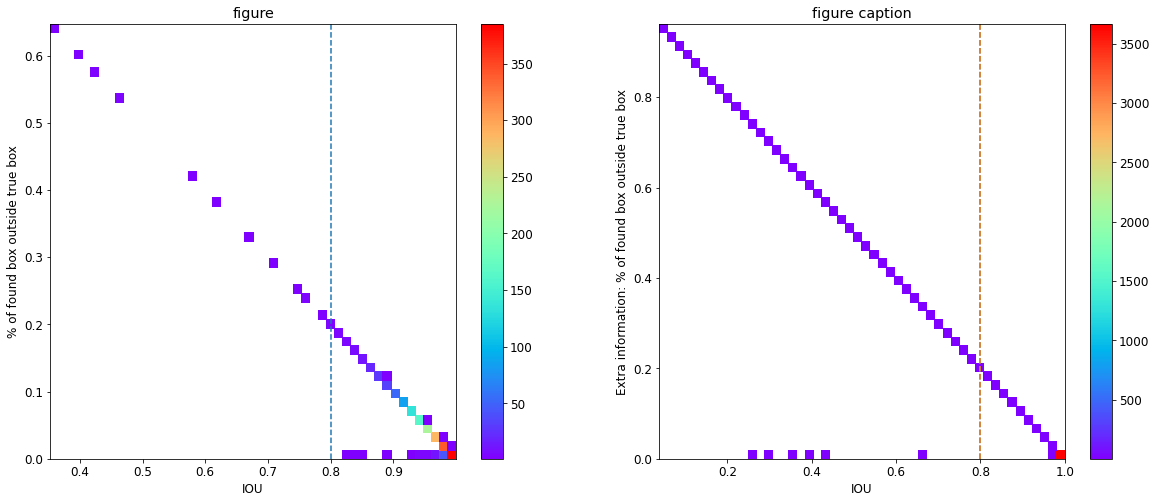

In [312]:
# what percent of area in found box is outside when true box is inside found box?
fig, ax = plt.subplots(1,2,figsize=(20,8))

nbins = 50

mask = area_figs<=0 # extra area is <= 0 excess
y = area_figs[mask]*-1.0
h=ax[0].hist2d(ious_figs[mask], y, cmap='rainbow',cmin=1, bins=nbins)#, weights=weights)
ax[0].set_title('figure')
ax[0].set_xlabel('IOU')
ax[0].set_ylabel('% of found box outside true box')
#ax[0].set_xlim(0.0,1.0)
ax[0].plot([0.8,0.8],[0,1.0], '--')
fig.colorbar(h[3], ax=ax[0])

mask = area_caps<=0 # extra area is <= 0 excess
y = area_caps[mask]*-1.0
h=ax[1].hist2d(ious_caps[mask], y, cmap='rainbow',cmin=1, bins=nbins)
ax[1].set_title('figure caption')
ax[1].set_xlabel('IOU')
ax[1].set_ylabel('Extra information: % of found box outside true box')
#ax[1].set_xlim(0.0,1.0)
#ax[1].set_ylim(0,1.0)
ax[1].plot([0.8,0.8],[0,1.0], '--')
fig.colorbar(h[3], ax=ax[1])
ax[1].plot([0.8,0.8],[0,1.0], '--')

The above tells us that at an IOU of 0.8, the typical "extra" information we have around figures is $\lesssim 20\%$ with the majority of instances having extra information is about $5\%$ (where the red is).

For figure captions, whenever the found figure caption is larger or equal to the true caption

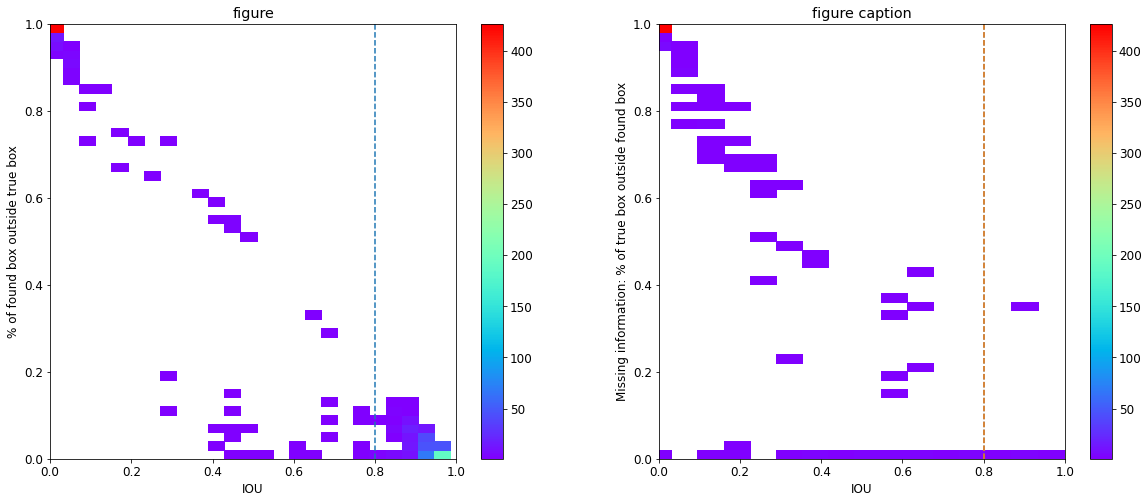

In [248]:
# outside if not inside
# what percent of area in found box is outside when true box is inside found box?
fig, ax = plt.subplots(1,2,figsize=(20,8))
nbins = 50
y = area_figs[area_figs>=0]
h=ax[0].hist2d(ious_figs[area_figs>=0], y, cmap='rainbow',cmin=1, bins=nbins)#, weights=weights)
ax[0].set_title('figure')
ax[0].set_xlabel('IOU')
ax[0].set_ylabel('% of found box outside true box')
ax[0].set_xlim(0.0,1.0)
ax[0].plot([0.8,0.8],[0,1.0], '--')
fig.colorbar(h[3], ax=ax[0])


y = area_caps[area_caps>=0]
h=ax[1].hist2d(ious_caps[area_caps>=0], y, cmap='rainbow',cmin=1, bins=nbins)
ax[1].set_title('figure caption')
ax[1].set_xlabel('IOU')
ax[1].set_ylabel('Missing information: % of true box outside found box')
ax[1].set_xlim(0.0,1.0)
ax[1].set_ylim(0,1.0)
ax[1].plot([0.8,0.8],[0,1.0], '--')
fig.colorbar(h[3], ax=ax[1])
ax[1].plot([0.8,0.8],[0,1.0], '--')

In [ ]:
ax[0].hist

In [316]:
isRectangleOverlap([0,0,2,2],[1,1,3,3])

True

In [317]:
isRectangleOverlap([1,1,3,3],[0,0,2,2])

True

In [318]:
x = [1,1,3,3,-1]
x[:-1]

[1, 1, 3, 3]

In [155]:
fn2 = []
for fn,iou,c in zip(names_figs,ious_figs,covered_figs):
    if c == 0 and iou > 0.95:
        fn2.append(fn)
len(fn2)

227

In [156]:
fn2[2], covered_figs[2]

('1905ApJ____22__123W_p6', 1)

In [284]:
i = 2 # plot a weirdo
fn_ind = fnames.index(fn2[i])
fn_ind = 687 # iou>1
img = np.array(Image.open(images_pulled_dir+fnames[fn_ind]+'.jpeg').convert('RGB'))
# overplot
xfrac = img.shape[1]/512.; yfrac = img.shape[0]/512.
for f in founds[fn_ind][0]:
    cv.rectangle( img, (round(f[0]*xfrac), round(f[1]*yfrac)), 
                 (round(f[2]*xfrac), round(f[3]*yfrac)), (255, 0, 0), 7 )
for t in trues[fn_ind]:
    cv.rectangle( img, (round(t[0]*xfrac), round(t[1]*yfrac)), 
                 (round(t[2]*xfrac), round(t[3]*yfrac)), (0, 0, 255), 3 )


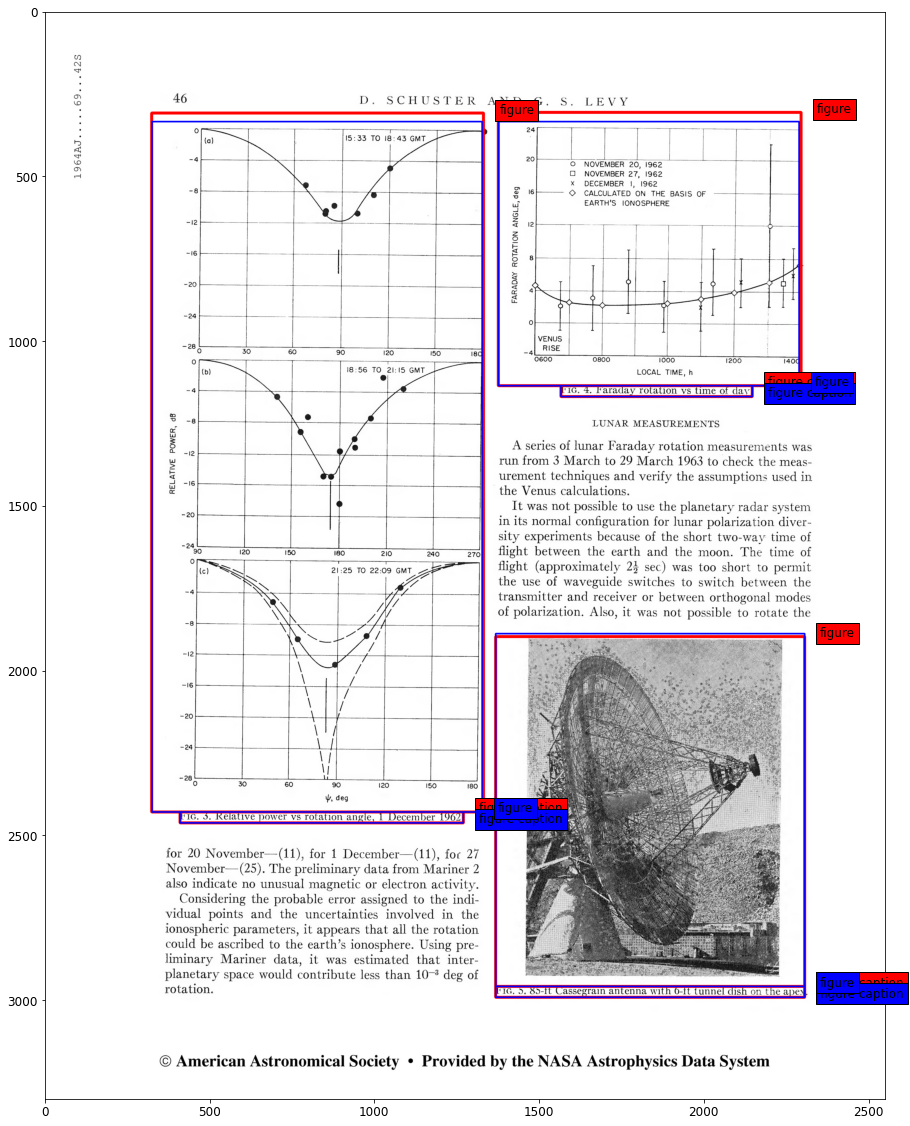

In [285]:
fig,ax = plt.subplots(figsize=(18,20))

ax.imshow(img)
xoffset = 50
for f,l in zip(founds[fn_ind][0],founds[fn_ind][1]):
    xt = f[2]*xfrac+xoffset; yt = f[1]*yfrac
    ax.text(xt, yt, np.array(LABELS)[int(l)], 
           bbox=dict(facecolor='red'))
    
for t in trues[fn_ind]:
    xt = t[2]*xfrac+xoffset; yt = t[3]*yfrac
    ax.text(xt, yt, np.array(LABELS)[int(t[-1]-1)], 
           bbox=dict(facecolor='blue'))

plt.show()

In [159]:
covered_figs[i]

1

In [160]:
founds[fn_ind]

[[array([378.27764706, 142.73939394, 394.9427451 , 340.24727273]),
  (135.20791625976562,
   72.51885986328125,
   378.2776470588235,
   434.47857666015625)],
 [1, 0],
 [0.99985373, 0.9999881]]

In [150]:
trues[fn_ind]

[array([388.11607843,  89.67757576, 411.0054902 , 370.19151515,
          2.        ]),
 array([146.        ,  65.        , 388.11607843, 392.        ,
          1.        ])]

In [39]:
# ss = []
# for s in save_ious:
#     for sss in s:
#         ss.append(sss)

In [40]:
precision = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
recall = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
f1 = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])

# from CV
precision_std = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
recall_std = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
f1_std = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])

use_sum = False
for j in range(len(iouminVec)):
    for i in range(len(scoreminVec)):
        if use_sum: # this might not be the right way to calculate this...probably want mean ...
            p = np.sum(TPv[:,i,j],axis=1)/(np.sum(TPv[:,i,j],axis=1)+np.sum(FPv[:,i,j],axis=1))*100
            r = np.sum(TPv[:,i,j],axis=1)/(np.sum(TPv[:,i,j],axis=1)+np.sum(FNv[:,i,j],axis=1))*100
            f = 2.0*(r*p)/(r+p)
        else: # I'm not 100% sure this is what we want to do...
            #ps = []; rs = []; fs= []
            p = TPv[:,i,j]/(TPv[:,i,j]+FPv[:,i,j])*100
            p[TPv[:,i,j]+FPv[:,i,j]<=0] = 0
            r = TPv[:,i,j]/(TPv[:,i,j]+FNv[:,i,j])*100
            r[TPv[:,i,j]+FNv[:,i,j]<=0] = 0
            #print(p)#,r)
            f = 2.0*(r*p)/(r+p)
            f[r+p <=0] = 0
            precision_std[:,i,j] = np.std(p,axis=1)
            recall_std[:,i,j] = np.std(r,axis=1)
            f1_std[:,i,j] = np.std(f,axis=1)
            # I feel like re-writing this migth be the issue...
            #p = np.mean(TPv[:,i,j],axis=1)/(np.mean(TPv[:,i,j],axis=1)+np.mean(FPv[:,i,j],axis=1))*100
            #r = np.mean(TPv[:,i,j],axis=1)/(np.mean(TPv[:,i,j],axis=1)+np.mean(FNv[:,i,j],axis=1))*100
            #f = 2.0*(r*p)/(r+p)
            p = np.mean(p, axis=1)
            r = np.mean(r, axis=1)
            f = np.mean(f, axis=1)
            
        precision[:,i,j] = p
        recall[:,i,j] = r
        f1[:,i,j] = f
        # for stddev... 
        

/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


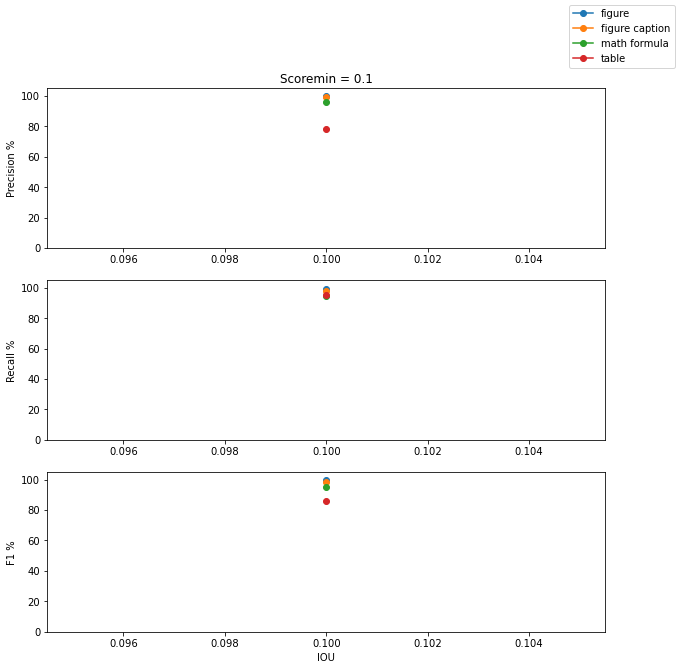

In [41]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

In [40]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [41]:
iouminVec

array([0.1 , 0.6 , 0.7 , 0.75, 0.8 , 0.9 , 0.95])

In [56]:
#ioumin_per_label = [0.5, 0.95, 0.5]
ioumin_per_label = [0.7, 0.95, 0.5]
ioumin_per_label = [0.8, 0.95, 0.5]
ioumin_per_label = [0.1, 0.6, 0.6] # ICDAR is 0.6 and 0.8
ioumin_per_label = [0.6, 0.6, 0.6, 0.6] # fig, fig+caption, math formula, table
ioumin_per_label = [0.1, 0.1, 0.1, 0.1] # fig, fig+caption, math formula, table
#ioumin_per_label = [0.8, 0.8, 0.8, 0.8] # fig, fig+caption, math formula, table
ioumin_per_label = [0.95, 0.95, 0.95, 0.95] # fig, fig+caption, math formula, table
ioumin_per_label = [0.8, 0.95, 0.8, 0.8] # fig, fig+caption, math formula, table

ioumin_per_label_ind = []
for i in ioumin_per_label:
    if i not in iouminVec:
        print('value', i, 'not one of', iouminVec)
    else:
        ioumin_per_label_ind.append(iouminVec.tolist().index(i))
print(ioumin_per_label, ioumin_per_label_ind)

[0.8, 0.95, 0.8, 0.8] [4, 6, 4, 4]


In [57]:
#scoremin = 0.95 #   = box_conf * box_class_prob => pick with CV!!!
#scoremin = 0.5 #   = box_conf * box_class_prob => pick with CV!!!
scoremin = 0.1 #   = box_conf * box_class_prob => pick with CV!!!
#ioumin = 0.95

sind = np.where(scoreminVec == scoremin)[0];
TP = np.zeros([len(LABELS)]); FP = np.zeros([len(LABELS)]); FN = np.zeros([len(LABELS)])
THROWNOUT = np.zeros([len(LABELS)]); MISSCLASS = np.zeros([len(LABELS)])
totalTrue = np.zeros([len(LABELS)])

TPyear = np.zeros([len(years),len(LABELS)])
FPyear = np.zeros([len(years),len(LABELS)])
FNyear = np.zeros([len(years),len(LABELS)])
MISSCLASSyear = np.zeros([len(years),len(LABELS)])
THROWNOUTyear = np.zeros([len(years),len(LABELS)])
totalTrueyear = np.zeros([len(years),len(LABELS)])
for l in range(len(LABELS)):
    iind = np.where(iouminVec == ioumin_per_label[l])[0]
    TP[l] = np.sum(TPv[l,sind,iind]).flatten()
    FP[l] = np.sum(FPv[l, sind, iind]).flatten()
    FN[l] = np.sum(FNv[l, sind, iind]).flatten()
    THROWNOUT[l] = np.sum(THROWNOUTv[l, sind, iind]).flatten()
    MISSCLASS[l] = np.sum(MISSCLASSv[l, sind, iind]).flatten() 
    totalTrue[l] = np.sum(totalTruev[l, sind, iind]).flatten() 
    # by year
    if len(scoreminVec) > 1:
        TPyear[:,l] = TPyears[:,l,sind,iind].reshape(len(years))#,len(LABELS))
        FPyear[:,l] = FPyears[:,l,sind,iind].reshape(len(years))#,len(LABELS))
        FNyear[:,l] = FNyears[:,l,sind,iind].reshape(len(years))#,len(LABELS)) 
        MISSCLASSyear[:,l] = MISSCLASSyears[:,l,sind,iind].reshape(len(years))#,len(LABELS)) 
        THROWNOUTyear[:,l] = THROWNOUTyears[:,l,sind,iind].reshape(len(years))#,len(LABELS)) 
        totalTrueyear[:,l] = totalTrueyears[:,l,sind,iind].reshape(len(years))#,len(LABELS))
    else:
        TPyear[:,l] = TPyears[:,l,sind,iind].reshape(len(years))#,len(LABELS))
        FPyear[:,l] = FPyears[:,l,sind,iind].reshape(len(years))#,len(LABELS))
        FNyear[:,l] = FNyears[:,l,sind,iind].reshape(len(years))#,len(LABELS)) 
        MISSCLASSyear[:,l] = MISSCLASSyears[:,l,sind,iind].reshape(len(years))#,len(LABELS)) 
        THROWNOUTyear[:,l] = THROWNOUTyears[:,l,sind,iind].reshape(len(years))#,len(LABELS)) 
        totalTrueyear[:,l] = totalTrueyears[:,l,sind,iind].reshape(len(years))#,len(LABELS))


In [58]:
IMAGE_H

512

In [59]:
# get individual and save, if you wanna
if save_diagnostics:
    # delete all files
    for diagdir in [fp_dir_orig,fn_dir_orig,tp_dir_orig]:
        for f in os.listdir(diagdir):
            os.remove(os.path.join(diagdir, f))
    print('done removing')
    print('start FP')
    # False positivies
    for ifp,fp in enumerate(np.array(FPsave)):
        fph = [0,0,0]
        for l in range(len(LABELS)):
            fph[l] = fp[l,ioumin_per_label_ind[l],sind][0]
        if np.sum(fph) > 0: # we got at least one FP
            img = np.array(Image.open(images_pulled_dir+fnames[ifp]+'.jpeg').convert("RGB"))
            fracx = img.shape[1]*1.0/IMAGE_W; fracy = img.shape[0]*1.0/IMAGE_H
            # plot found
            for idet,det in enumerate(founds[ifp][0]):
                c1 = (round(det[0]*fracx),round(det[1]*fracy)); 
                c2 = (round(det[2]*fracx), round(det[3]*fracy))
                cv.rectangle(img,c1,c2, (255,0,0), 7)
            # plot true
            for g in trues[ifp]:
                c1 = (round(g[0]*fracx),round(g[1]*fracy)); 
                c2 = (round(g[2]*fracx), round(g[3]*fracy))
                cv.rectangle(img,c1,c2, (0,0,255), 3) 
            Image.fromarray(img).save(fp_dir_orig+fnames[ifp]+'.jpeg')
            del img      
#     # True Positives
#     print('start TP')
#     for ifp,fp in enumerate(np.array(TPsave)):
#         fph = [0,0,0]
#         for l in range(len(LABELS)):
#             fph[l] = fp[l,ioumin_per_label_ind[l],sind][0]
#         if np.sum(fph) > 0: # we got at least one FP
#             img = np.array(Image.open(images_pulled_dir+fnames[ifp]+'.jpeg').convert("RGB"))
#             fracx = img.shape[1]*1.0/IMAGE_W; fracy = img.shape[0]*1.0/IMAGE_H
#             # plot found
#             for idet,det in enumerate(founds[ifp][0]):
#                 c1 = (round(det[0]*fracx),round(det[1]*fracy)); 
#                 c2 = (round(det[2]*fracx), round(det[3]*fracy))
#                 cv.rectangle(img,c1,c2, (255,0,0), 7)
#             # plot true
#             for g in trues[ifp]:
#                 c1 = (round(g[0]*fracx),round(g[1]*fracy)); 
#                 c2 = (round(g[2]*fracx), round(g[3]*fracy))
#                 cv.rectangle(img,c1,c2, (0,0,255), 3) 
#             Image.fromarray(img).save(tp_dir_orig+fnames[ifp]+'.jpeg')
#             del img             
    # False negatives
    print('start FN')
    for ifp,fp in enumerate(np.array(FNsave)):
        fph = [0,0,0]
        for l in range(len(LABELS)):
            fph[l] = fp[l,ioumin_per_label_ind[l],sind][0]
        if np.sum(fph) > 0: # we got at least one FP
            img = np.array(Image.open(images_pulled_dir+fnames[ifp]+'.jpeg').convert("RGB"))
            fracx = img.shape[1]*1.0/IMAGE_W; fracy = img.shape[0]*1.0/IMAGE_H
            # plot found
            for idet,det in enumerate(founds[ifp][0]):
                c1 = (round(det[0]*fracx),round(det[1]*fracy)); 
                c2 = (round(det[2]*fracx), round(det[3]*fracy))
                cv.rectangle(img,c1,c2, (255,0,0), 7)
            # plot true
            for g in trues[ifp]:
                c1 = (round(g[0]*fracx),round(g[1]*fracy)); 
                c2 = (round(g[2]*fracx), round(g[3]*fracy))
                cv.rectangle(img,c1,c2, (0,0,255), 3) 
                
#             # final sqs
#             for idet,det in enumerate(founds2[ifp]):
#                 c1 = (round(det[0]*fracx),round(det[1]*fracy)); 
#                 c2 = (round(det[2]*fracx), round(det[3]*fracy))
#                 cv.rectangle(img,c1,c2, (125,0,125), 7)
#             # plot true
#             for g in trues2[ifp]:
#                 c1 = (round(g[0]*fracx),round(g[1]*fracy)); 
#                 c2 = (round(g[2]*fracx), round(g[3]*fracy))
#                 cv.rectangle(img,c1,c2, (0,125,125), 3) 
            Image.fromarray(img).save(fn_dir_orig+fnames[ifp]+'.jpeg')
            del img             


In [60]:
df = pd.DataFrame({'years':years})
df['years'] = pd.to_datetime(df['years'],format="%Y")

# total each year
for il,l in enumerate(LABELS):
    df['total:'+l] = totalTrueyear[:,il]

# miss classifications per year
for il,l in enumerate(LABELS):
    colname = 'MS:' + l
    df[colname] = MISSCLASSyear[:,il]
    
# true positive per year
for il,l in enumerate(LABELS):
    colname = 'TP:' + l
    df[colname] = TPyear[:,il]
    
# false positive each year
for il,l in enumerate(LABELS):
    colname = 'FP:' + l
    df[colname] = FPyear[:,il]
    
# false negative each year
for il,l in enumerate(LABELS):
    colname = 'FN:' + l
    df[colname] = FNyear[:,il]
    
# precision per year - TP[i]/(TP[i]+FP[i])
for il,l in enumerate(LABELS):
    colname = 'prec:' + l
    df[colname] = 100*TPyear[:,il]/(TPyear[:,il]+FPyear[:,il])
    
# recall each year - TP[i]/(TP[i]+FN[i])
for il,l in enumerate(LABELS):
    colname = 'rec:' + l
    df[colname] = 100*TPyear[:,il]/(TPyear[:,il]+FNyear[:,il])

# f1 each year -- 2.0*(rec*prec)/(rec+prec)*100
for il,l in enumerate(LABELS):
    colname = 'F1:' + l
    p = TPyear[:,il]/(TPyear[:,il]+FPyear[:,il]); r = TPyear[:,il]/(TPyear[:,il]+FNyear[:,il])
    df[colname] = 100*(2.0*r*p)/(r+p)

/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/wwtProject3.7/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [61]:
#df

In [62]:
#print('IOU thresh = ', ioumin, ' SCORE = ', scoremin, ' N_CV = ', n_folds_cv)
print('SCORE = ', scoremin, ' N_CV = ', n_folds_cv)

labelsMetric = ['Metric']
labelsMetric.extend(LABELS)
spacing = '%-15s'
strOut = ' '.join([spacing % (i,) for i in labelsMetric])
print(strOut)

out = ['iou cut']
for i in range(len(LABELS)):
    out.append( str(ioumin_per_label[i]) )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['# of objs']
for i in range(len(LABELS)):
    out.append( str(totalTrue[i]) )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

print('--------------------------------------------------------------------------------------------')

# out = ['thrownout']
# for i in range(len(LABELS)):
#     out.append( str(round(THROWNOUT[i]/totalTrue[i]*100,1))+'%' )
# strOut = ' '.join([spacing % (i,) for i in out])
# print(strOut)

# out = ['missclass']
# for i in range(len(LABELS)):
#     out.append( str(round(MISSCLASS[i]/totalTrue[i]*100,1))+'%' )
# strOut = ' '.join([spacing % (i,) for i in out])
# print(strOut)

out = ['TP']
for i in range(len(LABELS)):
    out.append( str(round(TP[i]/totalTrue[i]*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['FP']
for i in range(len(LABELS)):
    out.append( str(round(FP[i]/totalTrue[i]*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['FN']
for i in range(len(LABELS)):
    out.append( str(round(FN[i]/totalTrue[i]*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

print('--------------------------------------------------------------------------------------------')
out = ['Precision'] # accuracy of positive predictions => number of true positives out of all of the things we label as positive
for i in range(len(LABELS)):
    #out.append( str(round(TP[i]/(TP[i]+FP[i])*100,1))+'%' )
    iind = np.where(iouminVec == ioumin_per_label[i])[0]
    out.append( str(np.round(precision[i,sind,iind][0],1))+'+/-' +str(np.round(precision_std[i,sind,iind][0],1))+ '%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['Recall'] # true positive rate => number of true positives over all of the things that SHOULD be positive
for i in range(len(LABELS)):
    #out.append( str(round(TP[i]/(TP[i]+FN[i])*100,1))+'%' )
    iind = np.where(iouminVec == ioumin_per_label[i])[0]
    out.append( str(np.round(recall[i,sind,iind][0],1))+'+/-' +str(np.round(recall_std[i,sind,iind][0],1))+ '%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['F1']
for i in range(len(LABELS)):
    #prec = TP[i]/(TP[i]+FP[i]); rec = TP[i]/(TP[i]+FN[i])
    #out.append( str(round(2.0*(rec*prec)/(rec+prec)*100,1))+'%' )
    iind = np.where(iouminVec == ioumin_per_label[i])[0]
    out.append( str(np.round(f1[i,sind,iind][0],1))+'+/-' +str(np.round(f1_std[i,sind,iind][0],1))+ '%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

# Kahu is ~86% F1 at IOU of 0.8

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.95            0.8             0.8            
# of objs       494.0           472.0           114.0           75.0           
--------------------------------------------------------------------------------------------
TP              92.1%           87.7%           21.1%           45.3%          
FP              1.2%            1.7%            7.9%            33.3%          
FN              7.9%            12.3%           78.9%           54.7%          
--------------------------------------------------------------------------------------------
Precision       98.8+/-1.1%     98.2+/-1.4%     60.6+/-37.3%    59.7+/-7.8%    
Recall          92.0+/-1.9%     87.6+/-3.1%     16.5+/-15.2%    45.7+/-14.3%   
F1              95.3+/-0.9%     92.6+/-1.7%     23.0+/-17.2%    50.4+/-10.9%   


### Also calc for combined figure+caption:

In [ ]:
#founds, trues
#trues[0]
#rinds

In [ ]:
# so, it might be a little silly that we are doing this again, BUT maybe its not
iouComb = 0.8
TPs = np.zeros([n_folds_cv]); totalTrues = np.zeros([n_folds_cv]); 
FPs = np.zeros([n_folds_cv]); FNs = np.zeros([n_folds_cv])
truesComb = []; foundsComb = []

# place randomly
rinds = np.random.randint(0,n_folds_cv, len(fnames))

#iit = 1
ttt=0

for iit in range(len(rotatedImages)):
    truebox1 = trues[iit]; rotatedImage = rotatedImages[iit]

    boxes_true_fig = []; boxes_true_cap = []; boxesCombTrue = []
    # also, save fig+cap combos
    for it,tbox in enumerate(truebox1):
        if LABELS[int(tbox[-1]-1)] == 'figure caption':
            boxes_true_cap.append(tbox.copy())
        elif LABELS[int(tbox[-1]-1)] == 'figure':
            if type(tbox) != tuple:
                boxes_true_fig.append(tbox.copy())
            else:
                boxes_true_fig.append(tbox)

    # pair
    for ibb,bb in enumerate(boxes_true_fig):
        mind = 5e15; iout = -1
        xc,yc = 0.5*(bb[0]+bb[2]),bb[3]
        if rotatedImage:
            xc, yc = bb[2], 0.5*(bb[1]+bb[3])
        for ic,bc in enumerate(boxes_true_cap): # find closest to bottom, not inside a square
            xcc,ycc= 0.5*(bc[0]+bc[2]),0.5*(bc[1]+bc[3])
            d = np.sum(((xc-xcc)**2 + (yc-ycc)**2)**0.5)
            if d < mind:
                mind = d
                iout = ic
        if iout > -1: # if we found a mega-yolo-found caption, add it
            boxesCombTrue.append( (min(boxes_true_fig[ibb][0],boxes_true_cap[iout][0]),
                                   min(boxes_true_fig[ibb][1],boxes_true_cap[iout][1]),
                                   max(boxes_true_fig[ibb][2],boxes_true_cap[iout][2]),
                                   max(boxes_true_fig[ibb][3],boxes_true_cap[iout][3]), 
                                  1) ) # 0 = placeholder tag
        else: # if no, just take fig
            boxesCombTrue.append( (boxes_true_fig[ibb][0], boxes_true_fig[ibb][1], 
                                  boxes_true_fig[ibb][2], boxes_true_fig[ibb][3], 1) )
    #print(len(boxes_true_fig), len(boxesCombTrue))
    ttt += len(boxes_true_fig)
    truesComb.append(boxesCombTrue)


    # no, for founds
    #truebox1 = trues[iit]; rotatedImage = rotatedImages[iit]

    boxes_fig = []; boxes_cap = []; boxesComb = []; labelsComb = []; scoresComb = []
    # also, save fig+cap combos
    for box,l in zip(founds[iit][0],founds[iit][1]):
        if LABELS[l] == 'figure caption':
            boxes_cap.append(box.copy())
        elif LABELS[l] == 'figure':
            if type(box) != tuple:
                boxes_fig.append(box.copy())
            else:
                boxes_fig.append(box)

    # pair
    for ibb,bb in enumerate(boxes_fig):
        mind = 5e15; iout = -1
        xc,yc = 0.5*(bb[0]+bb[2]),bb[3]
        if rotatedImage:
            xc, yc = bb[2], 0.5*(bb[1]+bb[3])
        for ic,bc in enumerate(boxes_cap): # find closest to bottom, not inside a square
            xcc,ycc= 0.5*(bc[0]+bc[2]),0.5*(bc[1]+bc[3])
            d = np.sum(((xc-xcc)**2 + (yc-ycc)**2)**0.5)
            if d < mind:
                mind = d
                iout = ic
        if iout > -1: # if we found a mega-yolo-found caption, add it
            boxesComb.append( (min(boxes_fig[ibb][0],boxes_cap[iout][0]),
                                   min(boxes_fig[ibb][1],boxes_cap[iout][1]),
                                   max(boxes_fig[ibb][2],boxes_cap[iout][2]),
                                   max(boxes_fig[ibb][3],boxes_cap[iout][3]) 
                                  ) ) # 0 = placeholder tag
            labelsComb.append(0)
            scoresComb.append(1.0) # placeholder
        else: # if no, just take fig
            boxesComb.append( (boxes_fig[ibb][0], boxes_fig[ibb][1], 
                                  boxes_fig[ibb][2], boxes_fig[ibb][3]) )
            labelsComb.append(0)
            scoresComb.append(1.0) # placeholder
    foundsComb.append((boxesComb,labelsComb,scoresComb))

    # bad code:
    totalTruev1, TPv1, FPv1, FNv1 = calc_metrics(boxesCombTrue, 
                                        boxesComb, labelsComb, scoresComb, LABELS,iouComb)
    # only the "fake" index
    totalTrues[rinds[iit]] += totalTruev1[0]; 

    #tttt += totalTruev1[0]
    #print(totalTruev1[0])
    #print(' ')
    TPs[rinds[iit]] += TPv1[0]; 
    FPs[rinds[iit]] += FPv1[0]; FNs[rinds[iit]] += FNv1[0]

In [ ]:
#print('IOU thresh = ', ioumin, ' SCORE = ', scoremin, ' N_CV = ', n_folds_cv)
print('SCORE = ', scoremin, ' N_CV = ', n_folds_cv)

labelsMetric = ['Metric']
labelsMetric.extend(['fig+caption'])
spacing = '%-15s'
strOut = ' '.join([spacing % (i,) for i in labelsMetric])
print(strOut)

out = ['iou cut']
for i in range(1):
    out.append( str(iouComb) )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['# of objs']
for i in range(1):
    out.append( str(np.sum(totalTrues)) )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

print('-------------------------------------')


out = ['TP']
for i in range(1):
    out.append( str(round(np.mean(TPs/totalTrues)*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['FP']
for i in range(1):
    out.append( str(round(np.mean(FPs/totalTrues)*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['FN']
for i in range(1):
    out.append( str(round(np.mean(FNs/totalTrues)*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

print('-------------------------------------')

out = ['prec']
for i in range(1):
    p = TPs/(TPs+FPs)
    out.append( str(round(np.mean(p)*100,1)) + '+/-'+str(round(np.std(p)*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['rec']
for i in range(1):
    r = TPs/(TPs+FNs)
    out.append( str(round(np.mean(r)*100,1)) + '+/-'+str(round(np.std(r)*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['F1']
for i in range(1):
    r = TPs/(TPs+FNs)
    p = TPs/(TPs+FPs)
    f1 = 2*p*r/(p+r)
    out.append( str(round(np.mean(r)*100,1)) + '+/-'+str(round(np.std(r)*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)


In [ ]:
# plot one of these fig+caption just in case:


In [ ]:
# histogram over what time bins?
sampleHist = '10Y' # 5 years

In [ ]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

In [ ]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    #print(qname+l, bname+l)
#     counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
#     tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
#     #quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
#     quant = pd.Series(index=tot.index,data=np.array(counts.values/tot.values))
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    #p = TPyear[:,il]/(TPyear[:,il]+FPyear[:,il]); r = TPyear[:,il]/(TPyear[:,il]+FNyear[:,il])
    #df[colname] = 100*(2.0*r*p)/(r+p)    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
    #import sys; sys.exit()
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

In [ ]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['prec:'+l])).resample(sampleHist).mean()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(18,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['rec:'+l])).resample(sampleHist).mean()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall: ' + l)
    ax[il].set_ylabel('Recall %')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_meanRecall_per_year.png')